# PROJET 5 - Catégorisez automatiquement des questions

L'objectif de ce projet est de développer un système de suggestion de tag pour le site Stack Overflow c'est-à-dire assigner automatiquement plusieurs tags pertinents à une question.

Nous avons à notre disposition des données disponible sur l'outil d’export de données de Stack Overflow, https://data.stackexchange.com/stackoverflow/query/new. Etant donné le grand nombre de données disponibles seules les données de la dernière année seront analysées en utilisant la requête SQL suivante : 

* SELECT * FROM posts
* WHERE Score > 1
* and ViewCount > 10
* and AnswerCount > 1
* and FavoriteCount > 1
* and CommentCount > 1
* and not Tags = ' '
* and not Body = ' '
* and not Title = ' '
* and CreationDate between '2017-01-01' and '2021-09-01'

A partir de ces données, nous devons :
* Pré-traiter les messages pour les rendre exploitables
* Utiliser une approche non supervisée pour extraire nos propres tags
* Comparer les résultats avec une approche supervisée et combiner les 2 méthodes
* Utiliser un logiciel de gestion de versions, comme Git
* Créer une interface API pour utiliser le générateur de tags retenu

# Importation des librairies

In [ ]:
# coding: utf-8

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats
import matplotlib.lines as mlines
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from scipy import stats as st
from bs4 import BeautifulSoup
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import string
import re
import gensim
import json
import spacy
from joblib import dump, load
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

# Chargement des jeux de données

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/OpenClassrooms/Projet_5/QueryResults.csv'
data_text = pd.read_csv(path, sep = ",")

# Première description du jeux de données

In [ ]:
data_text.head(3)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,52094242,1,52335832.0,NaN,2018-08-30 09:59:36,NaN,19,6078,<p>Problem statement: Extract sections from .d...,2587027.0,NaN,5195250.0,NaN,2018-09-05 08:49:10,2020-04-25 12:57:54,Is there any way to read .docx file include au...,<python><docx><python-docx>,2,9,9,NaN,NaN,CC BY-SA 4.0
1,52094320,1,NaN,NaN,2018-08-30 10:03:31,NaN,6,774,<p>I have a 4D xarray Dataset. I want to carry...,9974926.0,NaN,9974926.0,NaN,2018-08-30 15:39:45,2020-03-06 11:42:57,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>,2,3,4,NaN,NaN,CC BY-SA 4.0
2,45655671,1,45655722.0,NaN,2017-08-12 23:06:12,NaN,7,1146,<p>My original function to determine if a numb...,8371266.0,NaN,3002139.0,NaN,2017-08-13 01:11:57,2017-08-13 02:44:08,Check if prime big-o,<c++><big-o><asymptotic-complexity>,2,3,2,NaN,NaN,CC BY-SA 3.0


In [ ]:
print('Le jeu de données est composé de', data_text.shape[0], 'lignes et ', data_text.shape[1], 'colonnes.')

Le jeu de données est composé de 50000 lignes et  23 colonnes.


In [ ]:
data_text.dtypes

Id                         int64
PostTypeId                 int64
AcceptedAnswerId         float64
ParentId                 float64
CreationDate              object
DeletionDate             float64
Score                      int64
ViewCount                  int64
Body                      object
OwnerUserId              float64
OwnerDisplayName          object
LastEditorUserId         float64
LastEditorDisplayName     object
LastEditDate              object
LastActivityDate          object
Title                     object
Tags                      object
AnswerCount                int64
CommentCount               int64
FavoriteCount              int64
ClosedDate                object
CommunityOwnedDate       float64
ContentLicense            object
dtype: object

In [ ]:
data_text.isnull().sum().sum()

341964

In [ ]:
data_text.isnull().sum()

Id                           0
PostTypeId                   0
AcceptedAnswerId         16323
ParentId                 50000
CreationDate                 0
DeletionDate             50000
Score                        0
ViewCount                    0
Body                         0
OwnerUserId                690
OwnerDisplayName         49297
LastEditorUserId         13927
LastEditorDisplayName    49564
LastEditDate             13546
LastActivityDate             0
Title                        0
Tags                         0
AnswerCount                  0
CommentCount                 0
FavoriteCount                0
ClosedDate               48617
CommunityOwnedDate       50000
ContentLicense               0
dtype: int64

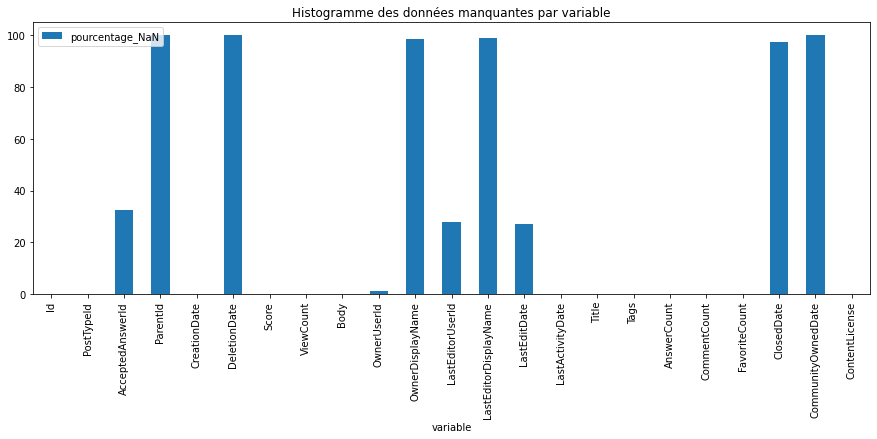

In [ ]:
## Données manquantes

dt = pd.DataFrame(data_text.isnull().sum(), columns=['nombre_NaN'])
dt = dt.rename_axis('variable').reset_index()
dt['pourcentage_NaN'] = dt['nombre_NaN']*100/data_text.shape[0]

plt.rcParams["figure.figsize"] = 15, 5
dt.plot(x='variable', y='pourcentage_NaN', kind = 'bar', title = 'Histogramme des données manquantes par variable', stacked = True)

In [ ]:
data_text['Body'].iloc[1]

'<p>I have a 4D xarray Dataset. I want to carry out a linear regression between two variables on a specific dimension (here time), and keep the regression parameters in a 3D array (the remaining dimensions).\nI managed to get the results I want by using this serial code, but it is rather slow:</p>\n\n<pre><code># add empty arrays to store results of the regression\nres_shape = tuple(v for k,v in ds[x].sizes.items() if k != \'year\')\nres_dims = tuple(k for k,v in ds[x].sizes.items() if k != \'year\')\nds[sl] = (res_dims, np.empty(res_shape, dtype=\'float32\'))\nds[inter] = (res_dims, np.empty(res_shape, dtype=\'float32\'))\n# Iterate in kept dimensions\nfor lat in ds.coords[\'latitude\']:\n    for lon in ds.coords[\'longitude\']:\n        for duration in ds.coords[\'duration\']:\n            locator = {\'longitude\':lon, \'latitude\':lat, \'duration\':duration}\n            sel = ds.loc[locator]\n            res = scipy.stats.linregress(sel[x], sel[y])\n            ds[sl].loc[locator] 

In [ ]:
data_text['Title'].iloc[1]

'With xarray, how to parallelize 1D operations on a multidimensional Dataset?'

In [ ]:
data_text['Tags'].iloc[1]

'<python><dask><python-xarray>'

In [ ]:
data_text[['Body', 'Title', 'Tags']]

,Body,Title,Tags
0,<p>Problem statement: Extract sections from .d...,Is there any way to read .docx file include au...,<python><docx><python-docx>
1,<p>I have a 4D xarray Dataset. I want to carry...,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>
2,<p>My original function to determine if a numb...,Check if prime big-o,<c++><big-o><asymptotic-complexity>
3,<p>I am trying to understand the meaning of th...,Meaning of dot in lm(y~.) in R,<r>
4,<p>So i'm doing a little personal project but ...,attributeerror: module 'cv2.face' has no attri...,<python><python-3.x><opencv3.0><opencv-contrib>
...,...,...,...
49995,<p>So ... I've tried to set my app to disable ...,Why doesn't my iOS app disable dark mode?,<ios><swift><ios13><xcode11><ios-darkmode>
49996,<p>Hello I am trying to integrate react-native...,Activity needs to be set if initial lifecycle ...,<android><reactjs><react-native>
49997,<p>What would be the best way to achieve the f...,Scroll down transformation and logo movement,<javascript><jquery><html><css>
49998,<p>I'm trying to send Push Notifications to AP...,"How to encode JWT for APN tokenization (.NET, C#)",<c#><.net><apple-push-notifications><token><jwt>


In [ ]:
data_text[['Body', 'Title', 'Tags']].isnull().sum().sum()

0

# Récupération du corpus de données

In [ ]:
data_text[['Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount']].describe(include='all')

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
count,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,17.514140,1.576341e+04,3.758880,4.798820,4.941420
std,38.920689,3.658278e+04,3.157635,3.563487,10.232976
min,2.000000,3.100000e+01,2.000000,2.000000,2.000000
25%,4.000000,1.735750e+03,2.000000,2.000000,2.000000
50%,8.000000,5.554000e+03,3.000000,4.000000,3.000000
75%,17.000000,1.521000e+04,4.000000,6.000000,5.000000
max,2572.000000,1.244269e+06,79.000000,71.000000,909.000000


In [ ]:
## Sélection des données intéressantes 

data = data_text[(data_text['Score'] > 1) & (data_text['ViewCount'] > 10) & (data_text['AnswerCount'] > 1) & (data_text['FavoriteCount'] > 1) & (data_text['CommentCount'] > 1)]
data.reset_index(inplace = True)
data

,index,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,0,52094242,1,52335832.0,NaN,2018-08-30 09:59:36,NaN,19,6078,<p>Problem statement: Extract sections from .d...,2587027.0,NaN,5195250.0,NaN,2018-09-05 08:49:10,2020-04-25 12:57:54,Is there any way to read .docx file include au...,<python><docx><python-docx>,2,9,9,NaN,NaN,CC BY-SA 4.0
1,1,52094320,1,NaN,NaN,2018-08-30 10:03:31,NaN,6,774,<p>I have a 4D xarray Dataset. I want to carry...,9974926.0,NaN,9974926.0,NaN,2018-08-30 15:39:45,2020-03-06 11:42:57,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>,2,3,4,NaN,NaN,CC BY-SA 4.0
2,2,45655671,1,45655722.0,NaN,2017-08-12 23:06:12,NaN,7,1146,<p>My original function to determine if a numb...,8371266.0,NaN,3002139.0,NaN,2017-08-13 01:11:57,2017-08-13 02:44:08,Check if prime big-o,<c++><big-o><asymptotic-complexity>,2,3,2,NaN,NaN,CC BY-SA 3.0
3,3,45655679,1,45656513.0,NaN,2017-08-12 23:07:11,NaN,7,7495,<p>I am trying to understand the meaning of th...,4752883.0,NaN,4497050.0,NaN,2017-08-12 23:55:18,2017-08-13 09:06:40,Meaning of dot in lm(y~.) in R,<r>,2,5,2,2017-08-14 08:14:09,NaN,CC BY-SA 3.0
4,4,45655699,1,NaN,NaN,2017-08-12 23:10:56,NaN,6,54023,<p>So i'm doing a little personal project but ...,8456422.0,NaN,3002139.0,NaN,2017-12-27 18:53:26,2021-06-27 07:08:30,attributeerror: module 'cv2.face' has no attri...,<python><python-3.x><opencv3.0><opencv-contrib>,18,2,3,NaN,NaN,CC BY-SA 3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,58609422,1,58611507.0,NaN,2019-10-29 14:26:32,NaN,10,6804,<p>So ... I've tried to set my app to disable ...,6828525.0,NaN,1265393.0,NaN,2020-04-03 01:15:37,2021-04-29 23:37:44,Why doesn't my iOS app disable dark mode?,<ios><swift><ios13><xcode11><ios-darkmode>,3,2,4,NaN,NaN,CC BY-SA 4.0
49996,49996,56946788,1,NaN,NaN,2019-07-09 06:51:00,NaN,11,1470,<p>Hello I am trying to integrate react-native...,8218937.0,NaN,3968276.0,NaN,2019-09-05 06:16:12,2019-09-06 08:34:22,Activity needs to be set if initial lifecycle ...,<android><reactjs><react-native>,2,2,2,NaN,NaN,CC BY-SA 4.0
49997,49997,41722844,1,41738872.0,NaN,2017-01-18 15:08:53,NaN,4,6518,<p>What would be the best way to achieve the f...,6278041.0,NaN,6799340.0,NaN,2017-01-18 15:14:28,2017-01-19 11:20:14,Scroll down transformation and logo movement,<javascript><jquery><html><css>,2,3,5,NaN,NaN,CC BY-SA 3.0
49998,49998,41722858,1,42532931.0,NaN,2017-01-18 15:09:30,NaN,5,2941,<p>I'm trying to send Push Notifications to AP...,3790083.0,NaN,3790083.0,NaN,2017-01-18 15:50:03,2020-11-10 07:49:04,"How to encode JWT for APN tokenization (.NET, C#)",<c#><.net><apple-push-notifications><token><jwt>,3,2,2,NaN,NaN,CC BY-SA 3.0


In [ ]:
data[['Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount']].describe(include='all')

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
count,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,17.514140,1.576341e+04,3.758880,4.798820,4.941420
std,38.920689,3.658278e+04,3.157635,3.563487,10.232976
min,2.000000,3.100000e+01,2.000000,2.000000,2.000000
25%,4.000000,1.735750e+03,2.000000,2.000000,2.000000
50%,8.000000,5.554000e+03,3.000000,4.000000,3.000000
75%,17.000000,1.521000e+04,4.000000,6.000000,5.000000
max,2572.000000,1.244269e+06,79.000000,71.000000,909.000000


In [ ]:
data = data[['Body', 'Title', 'Tags']].copy()

In [ ]:
data.isnull().sum()

Body     0
Title    0
Tags     0
dtype: int64

# Définition des fonctions

In [ ]:
## Suppression des balises HTML dans une question

def suppression_balises_html(row, variable):
  soup = BeautifulSoup(row[variable])
  for tag in soup.find_all('code'):
    tag.replaceWith('')
  question = soup.get_text()
  return question

In [ ]:
## Fréquence d'apparition des différents mots

def freq_stats_corpora():
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par question
    for num_ligne, message_dict in db.items():
      if pd.isnull(message_dict) == False : 
        #corpora[num_ligne] += tokenizer.tokenize(message_dict.encode().decode('utf-8').lower())
        #corpora[num_ligne] += (message_dict.encode().decode('utf-8').lower()).split()
        corpora[num_ligne] += ((message_dict.translate(str.maketrans('', '', string.punctuation))).encode().decode('utf-8').lower()).split()
      else : ## Messages avec NaN non présents dans le DataFrame
        pass

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v)} 
        
    return (freq, stats, corpora)


def freq_stats_corpora1():
    corpora = defaultdict(list)

    for num_ligne, message_dict in db.items():
      if pd.isnull(message_dict) == False : 
        # corpora[num_ligne] += tokenizer.tokenize(message_dict.encode().decode('utf-8').lower())
        corpora[num_ligne] += ((message_dict.translate(str.maketrans('', '', string.punctuation))).encode().decode('utf-8').lower()).split()
      else : 
        pass

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total' : len(v), 'unique' : len(fq.keys())}
        
    return (freq, stats, corpora)

def freq_stats_corpora2(lookup_table=[]):
    corpora = defaultdict(list)

    for num_ligne, message_dict in db.items():
      if pd.isnull(message_dict) == False : 
        #tokens = tokenizer.tokenize(message_dict.encode().decode('utf-8').lower())
        tokens = ((message_dict.translate(str.maketrans('', '', string.punctuation))).encode().decode('utf-8').lower()).split()
        corpora[num_ligne] += [w for w in tokens if not w in list(sw)]
      else : 
        pass

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
    return (freq, stats, corpora)

def freq_stats_corpora3(lookup_table=[]):
    corpora = defaultdict(list)

    for num_ligne, message_dict in db.items():
      if pd.isnull(message_dict) == False : 
        #tokens = tokenizer.tokenize(message_dict.encode().decode('utf-8').lower())
        tokens = ((message_dict.translate(str.maketrans('', '', string.punctuation))).encode().decode('utf-8').lower()).split()
        corpora[num_ligne] += [stemmer.stem(w) for w in tokens if not w in list(sw)]
      else:
        pass

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
    return (freq, stats, corpora)

def freq_stats_corpora4(lookup_table=[]):
    corpora = defaultdict(list)

    for num_ligne, message_dict in db.items():
      if pd.isnull(message_dict) == False : 
        #tokens = tokenizer.tokenize(message_dict.encode().decode('utf-8').lower())
        tokens = ((message_dict.translate(str.maketrans('', '', string.punctuation))).encode().decode('utf-8').lower()).split()
        corpora[num_ligne] += [lemmatizer.lemmatize(w) for w in tokens if not w in list(sw)]
      else:
        pass

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
    return (freq, stats, corpora)

In [ ]:
## Nettoyage des données en conservant uniquement les noms

nlp = spacy.load('en_core_web_sm')
# nlp = spacy.load('en_core_web_sm', disable=['ner'])

def conservation_noms(row, variable):

  ## Enlever la ponctuation
  question = row[variable].translate(str.maketrans('', '', string.punctuation))

  ## Mettre les mots en minuscule
  question = question.encode().decode('utf-8').lower()
  
  ## Conservation uniquement des noms
  sentence_nlp = []
  for word in nlp(question):
    if word.pos_ == 'NOUN':
      sentence_nlp.append(str(word))
      sentence_nlp.append(" ")
    elif word.pos_ == 'PROPN':
      sentence_nlp.append(str(word))
      sentence_nlp.append(" ")
    else:
      pass
  
  return "".join(sentence_nlp)

In [ ]:
## Nettoyage des données en fonction des différentes méthodes

def nettoyage_sans_traitement(row, variable):
  message_nettoye = row[variable]

  ## Supprimer les nombres seuls
  message_nettoye = re.sub(" \d+", " ", message_nettoye)

  ## Supprimer les mots à 1 lettre
  message_nettoye = message_nettoye.split()
  message_nettoye = [i for i in message_nettoye if len(i) > 1]
  sentence = []
  for word in message_nettoye:
    sentence.append(word)
    sentence.append(" ")
  message_nettoye = "".join(sentence)

  ## Supprimer les espaces
  message_nettoye = " ".join(message_nettoye.split())

  return message_nettoye

def nettoyage_stopwords(row, variable):
  message = row[variable]

  ## Tokeniser
  tokens = message.split()
  
  ## Suppression des stopwords
  sentence_stopwords = []
  for word in tokens:
    if word not in list(sw):
      sentence_stopwords.append(word)
      sentence_stopwords.append(" ")
    else:
      pass

  message_nettoye = "".join(sentence_stopwords)

  ## Supprimer les nombres seuls
  message_nettoye = re.sub(" \d+", " ", message_nettoye)

  ## Supprimer les mots à 1 lettre
  message_nettoye = message_nettoye.split()
  message_nettoye = [i for i in message_nettoye if len(i) > 1]
  sentence = []
  for word in message_nettoye:
    sentence.append(word)
    sentence.append(" ")
  message_nettoye = "".join(sentence)

  ## Supprimer les espaces
  message_nettoye = " ".join(message_nettoye.split())

  return message_nettoye
  

def nettoyage_lemmatisation(row, variable):
  message = row[variable]

  ## Tokeniser
  tokens = message.split()
  
  ## Lemmatisation
  lemmatizer = WordNetLemmatizer()
  sentence_lem = []
  for word in tokens:
    ## Suppression des stopwords
    if word not in list(sw):
      word_lem = lemmatizer.lemmatize(word)
      sentence_lem.append(word_lem)
      sentence_lem.append(" ")
    else:
      pass

  message_nettoye = "".join(sentence_lem)

  ## Supprimer les nombres seuls
  message_nettoye = re.sub(" \d+", " ", message_nettoye)

  ## Supprimer les mots à 1 lettre
  message_nettoye = message_nettoye.split()
  message_nettoye = [i for i in message_nettoye if len(i) > 1]
  sentence = []
  for word in message_nettoye:
    sentence.append(word)
    sentence.append(" ")
  message_nettoye = "".join(sentence)

  ## Supprimer les espaces
  message_nettoye = " ".join(message_nettoye.split())

  return message_nettoye
  

def nettoyage_stemming(row, variable):
  message = row[variable]

  ## Tokeniser
  tokens = message.split()
  
  ## Stemming
  stemmer = EnglishStemmer()
  sentence_stem = []
  
  for word in tokens:
    ## Suppression des stopwords
    if word not in list(sw):
      word_stem = stemmer.stem(word)
      sentence_stem.append(word_stem)
      sentence_stem.append(" ")
    else:
      pass

  message_nettoye = "".join(sentence_stem)

  ## Supprimer les nombres seuls
  message_nettoye = re.sub(" \d+", " ", message_nettoye)

  ## Supprimer les mots à 1 lettre
  message_nettoye = message_nettoye.split()
  message_nettoye = [i for i in message_nettoye if len(i) > 1]
  sentence = []
  for word in message_nettoye:
    sentence.append(word)
    sentence.append(" ")
  message_nettoye = "".join(sentence)

  ## Supprimer les espaces
  message_nettoye = " ".join(message_nettoye.split())

  return message_nettoye

In [ ]:
## Nettoyage des Tags

def nettoyage_tags(row):

  tags = row['Tags'] 
  tags = tags.encode().decode('utf-8').lower()

  tags_new = re.sub('<', "", tags)
  tags_new = re.sub('>',' ', tags_new)
  tags_new = tags_new[:-1]

  return tags_new

In [ ]:
## Conservation du Top des Tags les plus fréquents

def conservation_mots_frequents(row, liste_Tags_selectionne, variable):
  Tags = row[variable].encode().decode('utf-8').lower()

  sentence = []

  ## Tokeniser
  tokens = Tags.split()

  ## Sélection des Tags les plus fréquents
  for tags in tokens:
    if tags in liste_Tags_selectionne:
      sentence.append(tags)
      sentence.append(", ")
    else:
      pass
  
  return "".join(sentence[:-1])

In [ ]:
## Evaluation des Topics du modèle

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
## Top des mots de chaque Topic

def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [ ]:
## Création du dummies du match

def match_topic_dominant_message(row, variable, liste_Features):
  liste_topic = liste_Features
  message = row[variable].split()
  liste_match = [i for i in message if i in liste_topic]
  liste_match = list(set(liste_match))
  return liste_match

In [ ]:
## Graphe du nombre de données manquantes

def graphe_donnees_manquantes(data) :
  nb_donnees_tot = len(data)*len(data.columns)
  donnees_NaN = data.isnull().sum().sum()
  donnees_presentes = nb_donnees_tot - donnees_NaN
  
  x = np.array([donnees_NaN, donnees_presentes])
  label = ["Données manquantes", "Données présentes"]
  
  plt.pie(x, explode=(0.1, 0), labels=label, colors=['tomato', 'blue'], autopct='%1.1f%%', shadow=True, startangle=90)
  plt.title('Diagramme circulaire des données présentes et manquantes')
  plt.show()

# Prétraitement : Nettoyage des messages avec la variable 'Body'

## Nettoyage des Questions en enlevant les balises HTML

In [ ]:
## Affichage d'une question

message = data['Body'][1]
print(message)

<p>I have a 4D xarray Dataset. I want to carry out a linear regression between two variables on a specific dimension (here time), and keep the regression parameters in a 3D array (the remaining dimensions).
I managed to get the results I want by using this serial code, but it is rather slow:</p>

<pre><code># add empty arrays to store results of the regression
res_shape = tuple(v for k,v in ds[x].sizes.items() if k != 'year')
res_dims = tuple(k for k,v in ds[x].sizes.items() if k != 'year')
ds[sl] = (res_dims, np.empty(res_shape, dtype='float32'))
ds[inter] = (res_dims, np.empty(res_shape, dtype='float32'))
# Iterate in kept dimensions
for lat in ds.coords['latitude']:
    for lon in ds.coords['longitude']:
        for duration in ds.coords['duration']:
            locator = {'longitude':lon, 'latitude':lat, 'duration':duration}
            sel = ds.loc[locator]
            res = scipy.stats.linregress(sel[x], sel[y])
            ds[sl].loc[locator] = res.slope
            ds[inter].lo

In [ ]:
## Balises HTML

soup = BeautifulSoup(message)
print(soup.prettify())

<html>
 <body>
  <p>
   I have a 4D xarray Dataset. I want to carry out a linear regression between two variables on a specific dimension (here time), and keep the regression parameters in a 3D array (the remaining dimensions).
I managed to get the results I want by using this serial code, but it is rather slow:
  </p>
  <pre><code># add empty arrays to store results of the regression
res_shape = tuple(v for k,v in ds[x].sizes.items() if k != 'year')
res_dims = tuple(k for k,v in ds[x].sizes.items() if k != 'year')
ds[sl] = (res_dims, np.empty(res_shape, dtype='float32'))
ds[inter] = (res_dims, np.empty(res_shape, dtype='float32'))
# Iterate in kept dimensions
for lat in ds.coords['latitude']:
    for lon in ds.coords['longitude']:
        for duration in ds.coords['duration']:
            locator = {'longitude':lon, 'latitude':lat, 'duration':duration}
            sel = ds.loc[locator]
            res = scipy.stats.linregress(sel[x], sel[y])
            ds[sl].loc[locator] = res.slope

In [ ]:
## Suppression des balises HTML dans une question

for tag in soup.find_all('code'):
    tag.replaceWith('')

message = soup.get_text()
print(message)

I have a 4D xarray Dataset. I want to carry out a linear regression between two variables on a specific dimension (here time), and keep the regression parameters in a 3D array (the remaining dimensions).
I managed to get the results I want by using this serial code, but it is rather slow:

How could I speed-up and parallelize this operation?
I understand that  might be an option (and could be parallelized with dask), but I did not managed to get the parameters right.
The following questions are related but without an answer:

Applying numpy.polyfit to xarray Dataset
Python: How to find regression equation of multiple 3D
(lat-lon-time-value) dataArrays?
calculating cross-correlation function in xarray

Edit 2: move previous edit to an answer



In [ ]:
## Suppression des balises HTML dans la colonne de données

data['Body_new'] = data.apply(lambda row : suppression_balises_html(row, 'Body'), axis=1)
data[['Body_new', 'Body']].head(8)

,Body_new,Body
0,Problem statement: Extract sections from .docx...,<p>Problem statement: Extract sections from .d...
1,I have a 4D xarray Dataset. I want to carry ou...,<p>I have a 4D xarray Dataset. I want to carry...
2,My original function to determine if a number ...,<p>My original function to determine if a numb...
3,I am trying to understand the meaning of this ...,<p>I am trying to understand the meaning of th...
4,So i'm doing a little personal project but i k...,<p>So i'm doing a little personal project but ...
5,I'm having trouble using some ng-bootstrap dro...,<p>I'm having trouble using some ng-bootstrap ...
6,I would like to integrate vuetify's v-stepper ...,<p>I would like to integrate vuetify's <a href...
7,I have an engine that does some mathematical a...,<p>I have an engine that does some mathematica...


In [ ]:
## Chargement des données dans un dictionnaire

db = data['Body_new'].to_dict()
print('chargement de {} vers dans la db'.format(len(db.keys())))

chargement de 50000 vers dans la db


In [ ]:
message = data['Body_new'][1]
print(message)

I have a 4D xarray Dataset. I want to carry out a linear regression between two variables on a specific dimension (here time), and keep the regression parameters in a 3D array (the remaining dimensions).
I managed to get the results I want by using this serial code, but it is rather slow:

How could I speed-up and parallelize this operation?
I understand that  might be an option (and could be parallelized with dask), but I did not managed to get the parameters right.
The following questions are related but without an answer:

Applying numpy.polyfit to xarray Dataset
Python: How to find regression equation of multiple 3D
(lat-lon-time-value) dataArrays?
calculating cross-correlation function in xarray

Edit 2: move previous edit to an answer



## Tokenisation et analyse des fréquences

In [ ]:
## Tokenisation sur une question

message.split()

['I',
 'have',
 'a',
 '4D',
 'xarray',
 'Dataset.',
 'I',
 'want',
 'to',
 'carry',
 'out',
 'a',
 'linear',
 'regression',
 'between',
 'two',
 'variables',
 'on',
 'a',
 'specific',
 'dimension',
 '(here',
 'time),',
 'and',
 'keep',
 'the',
 'regression',
 'parameters',
 'in',
 'a',
 '3D',
 'array',
 '(the',
 'remaining',
 'dimensions).',
 'I',
 'managed',
 'to',
 'get',
 'the',
 'results',
 'I',
 'want',
 'by',
 'using',
 'this',
 'serial',
 'code,',
 'but',
 'it',
 'is',
 'rather',
 'slow:',
 'How',
 'could',
 'I',
 'speed-up',
 'and',
 'parallelize',
 'this',
 'operation?',
 'I',
 'understand',
 'that',
 'might',
 'be',
 'an',
 'option',
 '(and',
 'could',
 'be',
 'parallelized',
 'with',
 'dask),',
 'but',
 'I',
 'did',
 'not',
 'managed',
 'to',
 'get',
 'the',
 'parameters',
 'right.',
 'The',
 'following',
 'questions',
 'are',
 'related',
 'but',
 'without',
 'an',
 'answer:',
 'Applying',
 'numpy.polyfit',
 'to',
 'xarray',
 'Dataset',
 'Python:',
 'How',
 'to',
 'find',
 '

In [ ]:
# Récupération des comptages d'apparition des différents mots

freq, stats, corpora = freq_stats_corpora()
df = pd.DataFrame.from_dict(stats, orient='index').sort_values(by = 'total', ascending=False)
df

,total
9384,1638
40945,1613
24214,1608
34,1405
48668,1373
...,...
9568,0
17817,0
38282,0
47492,0


Text(0.5, 0, 'Index des messages')

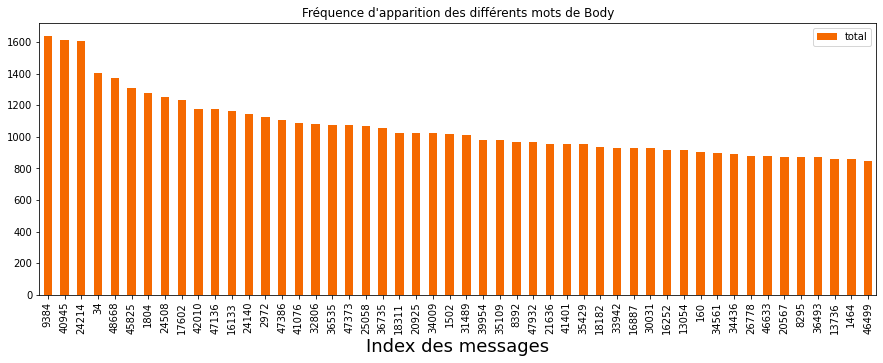

In [ ]:
## Affichage des fréquences

plt.rcParams["figure.figsize"] = [15, 5]
colors = ["#f56900"]
t = 'Fréquence d\'apparition des différents mots de Body'
df[:50].plot(kind = 'bar', color = colors, title = t, stacked = True)
plt.xlabel('Index des messages', fontsize=18)

In [ ]:
# Récupération des comptages des mots uniques utilisés dans les questions

freq1, stats1, corpora1 = freq_stats_corpora1()
df = pd.DataFrame.from_dict(stats1, orient='index').sort_values(by = 'total', ascending=False)
df

,total,unique
9384,1638,491
40945,1613,497
24214,1608,435
34,1405,511
48668,1373,461
...,...,...
9568,0,0
17817,0,0
38282,0,0
47492,0,0


Text(0.5, 0, 'Index des messages')

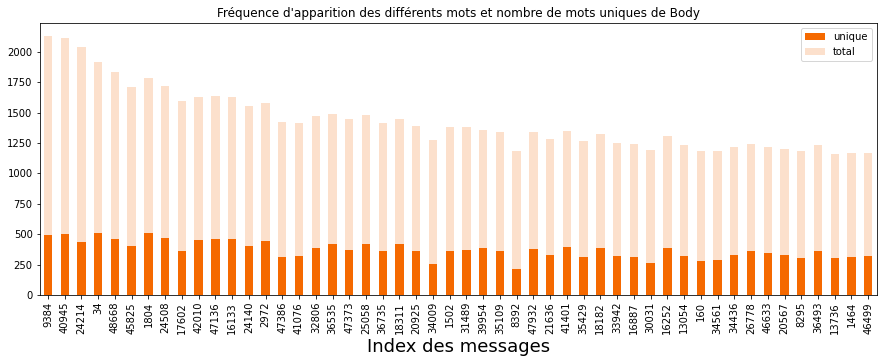

In [ ]:
## Affichage des fréquences et des mots uniques

plt.rcParams["figure.figsize"] = [15, 5]
colors = ["#f56900", "#fce0cc"]
t = 'Fréquence d\'apparition des différents mots et nombre de mots uniques de Body'
df[['unique', 'total']][:50].plot(kind = 'bar', color = colors, title = t, stacked = True)
plt.xlabel('Index des messages', fontsize=18)

## Création de la liste des stopwords

In [ ]:
## Fréquence des mots les plus utilisés

freq_totale = nltk.Counter()

for k, v in corpora.items():
    freq_totale += freq[k]

freq_totale.most_common(145)

[('the', 294148),
 ('i', 205368),
 ('to', 190530),
 ('a', 122526),
 ('is', 115677),
 ('and', 102495),
 ('in', 93017),
 ('this', 77458),
 ('of', 75566),
 ('it', 69607),
 ('that', 59530),
 ('for', 49137),
 ('my', 48694),
 ('but', 48633),
 ('with', 45882),
 ('have', 45701),
 ('on', 38381),
 ('not', 37496),
 ('be', 32914),
 ('as', 32354),
 ('can', 30204),
 ('an', 27490),
 ('using', 27258),
 ('am', 26289),
 ('from', 25738),
 ('if', 25359),
 ('code', 25216),
 ('when', 25109),
 ('how', 24520),
 ('like', 24141),
 ('so', 24065),
 ('im', 22293),
 ('or', 21513),
 ('are', 21288),
 ('do', 20503),
 ('there', 19842),
 ('error', 19404),
 ('what', 18988),
 ('which', 18802),
 ('use', 18593),
 ('get', 18056),
 ('any', 17877),
 ('want', 16344),
 ('all', 15842),
 ('would', 15307),
 ('file', 14676),
 ('by', 14091),
 ('at', 13761),
 ('way', 13722),
 ('some', 13551),
 ('following', 13414),
 ('here', 13306),
 ('one', 13144),
 ('tried', 12783),
 ('you', 12613),
 ('me', 11683),
 ('same', 11497),
 ('trying', 1149

In [ ]:
## Création de la liste des stopwords pour la variable 'Body_new'

sw = set()
most_freq = list(pd.DataFrame(freq_totale.most_common(145))[0])
default = nltk.corpus.stopwords.words('english')

sw.update(most_freq)
sw.update(tuple(default))
sw

{'1',
 '2',
 'a',
 'able',
 'about',
 'above',
 'add',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'app',
 'application',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'cant',
 'class',
 'code',
 'could',
 'couldn',
 "couldn't",
 'create',
 'd',
 'data',
 'did',
 'didn',
 "didn't",
 'different',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doesnt',
 'doing',
 'don',
 "don't",
 'dont',
 'down',
 'during',
 'each',
 'edit',
 'error',
 'example',
 'few',
 'file',
 'files',
 'find',
 'first',
 'following',
 'for',
 'found',
 'from',
 'function',
 'further',
 'get',
 'getting',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'help',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'however',
 'i',
 'if',
 'im',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'issue',
 'it',
 "i

In [ ]:
## Récupération des comptages et des fréquences en supprimant les stopwords

freq2, stats2, corpora2 = freq_stats_corpora2()
df2 = pd.DataFrame.from_dict(stats2, orient='index').sort_values(by = 'unique', ascending=False)
df2

,total,unique
34,752,395
1804,600,389
42010,947,384
9384,721,376
40945,641,372
...,...,...
43562,0,0
30615,0,0
8051,0,0
4811,0,0


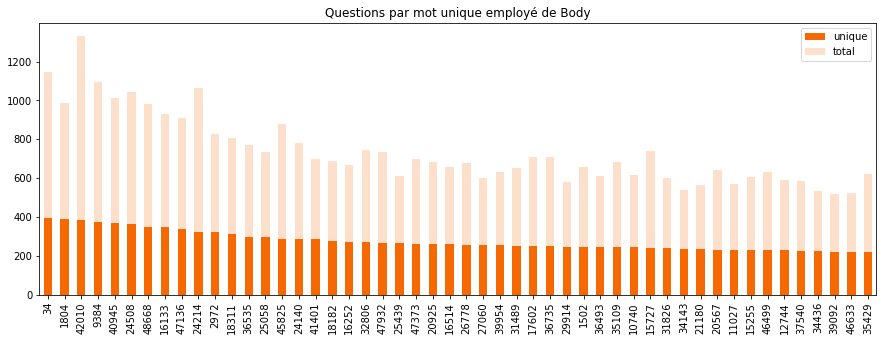

In [ ]:
## Affichage des fréquences et des mots uniques

plt.rcParams["figure.figsize"] = 15, 5
colors = ["#f56900", "#fce0cc"]
t = 'Questions par mot unique employé de Body'
df2[['unique', 'total']][:50].plot(kind = 'bar', color = colors, title = t, stacked = True)

In [ ]:
df_sw_body = pd.DataFrame(sw, columns=['sw_body'])
df_sw_body

,sw_body
0,however
1,first
2,do
3,will
4,what
...,...
249,further
250,both
251,of
252,solution


In [ ]:
## A partir de Google Colab

df_sw_body.to_csv('stopwords_body.csv', sep = ',', index=False)
files.download('stopwords_body.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Exploration du corpus de textes

### Stemming ou racinisation

In [ ]:
## Stemming sur une question

#tokenizer = nltk.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
tokens = (message.encode().lower().decode('utf-8')).split()
# tokens = tokenizer.tokenize(message.encode().lower().decode('utf-8'))
stemmed_tokens = [stemmer.stem(token) for token in tokens]

stemmed_tokens

['i',
 'have',
 'a',
 '4d',
 'xarray',
 'dataset.',
 'i',
 'want',
 'to',
 'carri',
 'out',
 'a',
 'linear',
 'regress',
 'between',
 'two',
 'variabl',
 'on',
 'a',
 'specif',
 'dimens',
 '(here',
 'time),',
 'and',
 'keep',
 'the',
 'regress',
 'paramet',
 'in',
 'a',
 '3d',
 'array',
 '(the',
 'remain',
 'dimensions).',
 'i',
 'manag',
 'to',
 'get',
 'the',
 'result',
 'i',
 'want',
 'by',
 'use',
 'this',
 'serial',
 'code,',
 'but',
 'it',
 'is',
 'rather',
 'slow:',
 'how',
 'could',
 'i',
 'speed-up',
 'and',
 'parallel',
 'this',
 'operation?',
 'i',
 'understand',
 'that',
 'might',
 'be',
 'an',
 'option',
 '(and',
 'could',
 'be',
 'parallel',
 'with',
 'dask),',
 'but',
 'i',
 'did',
 'not',
 'manag',
 'to',
 'get',
 'the',
 'paramet',
 'right.',
 'the',
 'follow',
 'question',
 'are',
 'relat',
 'but',
 'without',
 'an',
 'answer:',
 'appli',
 'numpy.polyfit',
 'to',
 'xarray',
 'dataset',
 'python:',
 'how',
 'to',
 'find',
 'regress',
 'equat',
 'of',
 'multipl',
 '3d',

In [ ]:
## Récupération des comptages des mots après Stemming

freq3, stats3, corpora3 = freq_stats_corpora3()
df3 = pd.DataFrame.from_dict(stats3, orient='index').sort_values(by = 'unique', ascending=False)
df3

,total,unique
42010,947,379
1804,600,344
34,752,340
40945,641,333
24508,677,330
...,...,...
17817,0,0
12362,0,0
8051,0,0
48731,0,0


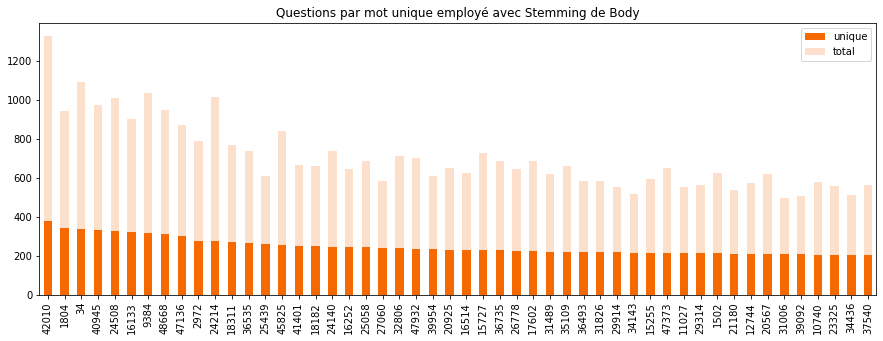

In [ ]:
## Affichage des fréquences et des mots uniques

plt.rcParams["figure.figsize"] = 15, 5
colors = ["#f56900", "#fce0cc"]
t = 'Questions par mot unique employé avec Stemming de Body'
df3[['unique', 'total']][:50].plot(kind = 'bar', color = colors, title = t, stacked = True)

### Lemmatisation

In [ ]:
## Lemmatisation sur une question

#tokenizer = nltk.RegexpTokenizer(r'\w+')

lemmatizer = WordNetLemmatizer()

tokens = (message.encode().lower().decode('utf-8')).split()
# tokens = tokenizer.tokenize(message.encode().lower().decode('utf-8'))
lemmat_tokens = [lemmatizer.lemmatize(token) for token in tokens]

lemmat_tokens

['i',
 'have',
 'a',
 '4d',
 'xarray',
 'dataset.',
 'i',
 'want',
 'to',
 'carry',
 'out',
 'a',
 'linear',
 'regression',
 'between',
 'two',
 'variable',
 'on',
 'a',
 'specific',
 'dimension',
 '(here',
 'time),',
 'and',
 'keep',
 'the',
 'regression',
 'parameter',
 'in',
 'a',
 '3d',
 'array',
 '(the',
 'remaining',
 'dimensions).',
 'i',
 'managed',
 'to',
 'get',
 'the',
 'result',
 'i',
 'want',
 'by',
 'using',
 'this',
 'serial',
 'code,',
 'but',
 'it',
 'is',
 'rather',
 'slow:',
 'how',
 'could',
 'i',
 'speed-up',
 'and',
 'parallelize',
 'this',
 'operation?',
 'i',
 'understand',
 'that',
 'might',
 'be',
 'an',
 'option',
 '(and',
 'could',
 'be',
 'parallelized',
 'with',
 'dask),',
 'but',
 'i',
 'did',
 'not',
 'managed',
 'to',
 'get',
 'the',
 'parameter',
 'right.',
 'the',
 'following',
 'question',
 'are',
 'related',
 'but',
 'without',
 'an',
 'answer:',
 'applying',
 'numpy.polyfit',
 'to',
 'xarray',
 'dataset',
 'python:',
 'how',
 'to',
 'find',
 'regre

In [ ]:
## Récupération des comptages des mots après Lemmatisation

freq4, stats4, corpora4 = freq_stats_corpora4()
df4 = pd.DataFrame.from_dict(stats4, orient='index').sort_values(by = 'unique', ascending=False)
df4

,total,unique
42010,947,381
34,752,376
1804,600,371
9384,721,360
40945,641,360
...,...,...
17817,0,0
47492,0,0
27780,0,0
6378,0,0


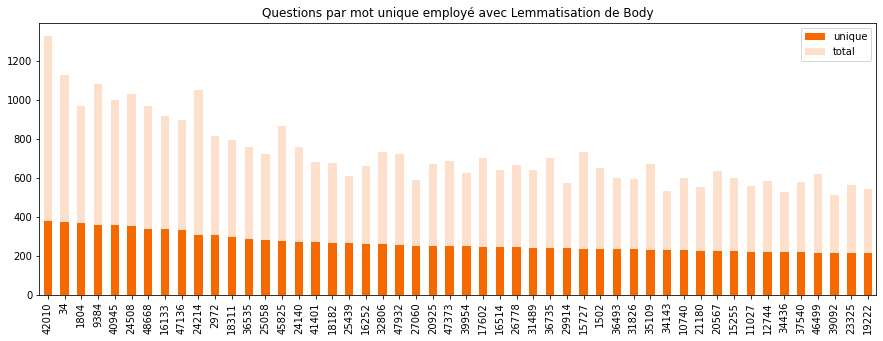

In [ ]:
## Affichage des fréquences et des mots uniques

plt.rcParams["figure.figsize"] = 15, 5
colors = ["#f56900", "#fce0cc"]
t = 'Questions par mot unique employé avec Lemmatisation de Body'
df4[['unique', 'total']][:50].plot(kind = 'bar', color = colors, title = t, stacked = True)

## Nettoyage des messages

Il est possible de tester différentes méthodes de nettoyage pour savoir quelle sera celle donnant les meilleures features : 
* sans nettoyage particulier
* en enlevant les stopwords
* avec lemmatisation ou stemming

In [ ]:
## Nettoyage des données en fonction des différents traitements

data['Body_noms'] = data.apply(lambda row : conservation_noms(row, 'Body_new'), axis=1)

data['Body_nettoye_sans'] = data.apply(lambda row : nettoyage_sans_traitement(row, 'Body_noms'), axis=1)
data['Body_nettoye_stopwords'] = data.apply(lambda row : nettoyage_stopwords(row, 'Body_noms'), axis=1)
data['Body_nettoye_lem'] = data.apply(lambda row : nettoyage_lemmatisation(row, 'Body_noms'), axis=1)
data['Body_nettoye_stem'] = data.apply(lambda row : nettoyage_stemming(row, 'Body_noms'), axis=1)

data[['Body', 'Body_new', 'Body_noms', 'Body_nettoye_sans', 'Body_nettoye_stopwords', 'Body_nettoye_lem', 'Body_nettoye_stem']].head(8)

,Body,Body_new,Body_noms,Body_nettoye_sans,Body_nettoye_stopwords,Body_nettoye_lem,Body_nettoye_stem
0,<p>Problem statement: Extract sections from .d...,Problem statement: Extract sections from .docx...,problem statement extract sections docx file a...,problem statement extract sections docx file a...,statement extract sections docx autonumbering ...,statement extract section docx autonumbering p...,statement extract section docx autonumb python...
1,<p>I have a 4D xarray Dataset. I want to carry...,I have a 4D xarray Dataset. I want to carry ou...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variable dimension r...,xarray dataset regress variabl dimens regress ...
2,<p>My original function to determine if a numb...,My original function to determine if a number ...,function number complexity optimizations check...,function number complexity optimizations check...,number complexity optimizations check bigo pro...,number complexity optimization check bigo prog...,number complex optim check bigo program fact
3,<p>I am trying to understand the meaning of th...,I am trying to understand the meaning of this ...,meaning statement r code r help section interp...,meaning statement code help section interpreta...,meaning statement section interpretations form...,meaning statement section interpretation formu...,mean statement section interpret formula conte...
4,<p>So i'm doing a little personal project but ...,So i'm doing a little personal project but i k...,project error recognizer opencvcontrib code li...,project error recognizer opencvcontrib code li...,recognizer opencvcontrib line modules thing la...,recognizer opencvcontrib line module thing lap...,recogn opencvcontrib line modul thing laptop d...
5,<p>I'm having trouble using some ng-bootstrap ...,I'm having trouble using some ng-bootstrap dro...,trouble ngbootstrap dropdown component depende...,trouble ngbootstrap dropdown component depende...,trouble ngbootstrap dropdown component depende...,trouble ngbootstrap dropdown component depende...,troubl ngbootstrap dropdown compon depend jque...
6,<p>I would like to integrate vuetify's <a href...,I would like to integrate vuetify's v-stepper ...,vuetifys vstepper vue router requirements step...,vuetifys vstepper vue router requirements step...,vuetifys vstepper vue router requirements step...,vuetifys vstepper vue router requirement step ...,vuetifi vstepper vue router requir step rout e...
7,<p>I have an engine that does some mathematica...,I have an engine that does some mathematical a...,engine operations formulas operands operators ...,engine operations formulas operands operators ...,engine operations formulas operands operators ...,engine operation formula operand operator oper...,engin oper formula operand oper oper scope res...


In [ ]:
data[['Body_nettoye_sans', 'Body_nettoye_stopwords', 'Body_nettoye_lem', 'Body_nettoye_stem']].isnull().sum()

Body_nettoye_sans         0
Body_nettoye_stopwords    0
Body_nettoye_lem          0
Body_nettoye_stem         0
dtype: int64

In [ ]:
print('Message initial : ')
print(data['Body'][1])
print('-------------------------------------------------------------------------------------')
print('Message sans les balises HTML : ')
print(data['Body_new'][1])
print('-------------------------------------------------------------------------------------')
print('Message sans traitement : ')
print(data['Body_nettoye_sans'][1])
print('-------------------------------------------------------------------------------------')
print('Message sans les stopwords : ')
print(data['Body_nettoye_stopwords'][1])
print('-------------------------------------------------------------------------------------')
print('Message après lematisation : ')
print(data['Body_nettoye_lem'][1])
print('-------------------------------------------------------------------------------------')
print('Message après stemming : ')
print(data['Body_nettoye_stem'][1])

Message initial : 
<p>I have a 4D xarray Dataset. I want to carry out a linear regression between two variables on a specific dimension (here time), and keep the regression parameters in a 3D array (the remaining dimensions).
I managed to get the results I want by using this serial code, but it is rather slow:</p>

<pre><code># add empty arrays to store results of the regression
res_shape = tuple(v for k,v in ds[x].sizes.items() if k != 'year')
res_dims = tuple(k for k,v in ds[x].sizes.items() if k != 'year')
ds[sl] = (res_dims, np.empty(res_shape, dtype='float32'))
ds[inter] = (res_dims, np.empty(res_shape, dtype='float32'))
# Iterate in kept dimensions
for lat in ds.coords['latitude']:
    for lon in ds.coords['longitude']:
        for duration in ds.coords['duration']:
            locator = {'longitude':lon, 'latitude':lat, 'duration':duration}
            sel = ds.loc[locator]
            res = scipy.stats.linregress(sel[x], sel[y])
            ds[sl].loc[locator] = res.slope
     

In [ ]:
## Suppression des messages vides

data = data[data['Body_new'] != '']
data = data[data['Body_nettoye_sans'] != '']
data = data[data['Body_nettoye_stopwords'] != '']
data = data[data['Body_nettoye_lem'] != '']
data = data[data['Body_nettoye_stem'] != '']

In [ ]:
data.reset_index(inplace = True)

In [ ]:
data.drop('index', axis=1, inplace=True)

# Prétraitement : Nettoyage des messages avec la variable 'Title'

In [ ]:
## Affichage d'un titre

message = data['Title'][0]
print(message)

Is there any way to read .docx file include auto numbering using python-docx


In [ ]:
## Chargement des données dans un dictionnaire

db = data['Title'].to_dict()
print('chargement de {} vers dans la db'.format(len(db.keys())))

chargement de 49865 vers dans la db


## Tokenisation et analyse des fréquences

In [ ]:
## Tokenisation sur une question

message.split()

['Is',
 'there',
 'any',
 'way',
 'to',
 'read',
 '.docx',
 'file',
 'include',
 'auto',
 'numbering',
 'using',
 'python-docx']

In [ ]:
# Récupération des comptages d'apparition des différents mots

freq, stats, corpora = freq_stats_corpora()
df = pd.DataFrame.from_dict(stats, orient='index').sort_values(by = 'total', ascending=False)
df

,total
49183,30
34899,30
24457,29
2338,29
47394,28
...,...
28312,2
38037,1
30146,1
26251,1


Text(0.5, 0, 'Index des messages')

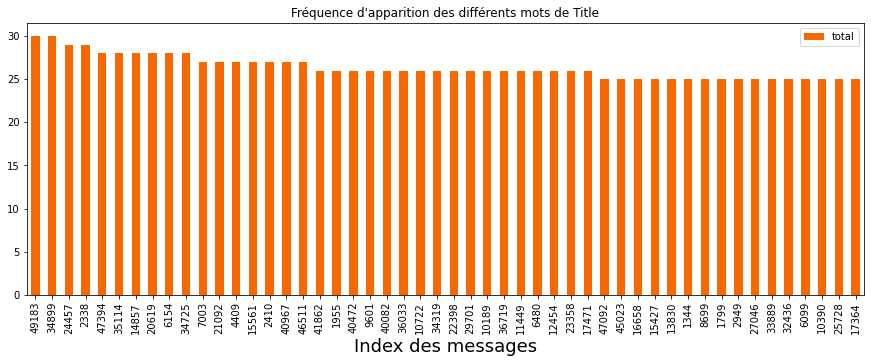

In [ ]:
## Affichage des fréquences

plt.rcParams["figure.figsize"] = [15, 5]
colors = ["#f56900"]
t = 'Fréquence d\'apparition des différents mots de Title'
df[:50].plot(kind = 'bar', color = colors, title = t, stacked = True)
plt.xlabel('Index des messages', fontsize=18)

In [ ]:
# Récupération des comptages des mots uniques utilisés dans les questions

freq1, stats1, corpora1 = freq_stats_corpora1()
df = pd.DataFrame.from_dict(stats1, orient='index').sort_values(by = 'total', ascending=False)
df

,total,unique
49183,30,23
34899,30,24
24457,29,27
2338,29,23
47394,28,27
...,...,...
28312,2,2
38037,1,1
30146,1,1
26251,1,1


Text(0.5, 0, 'Index des messages')

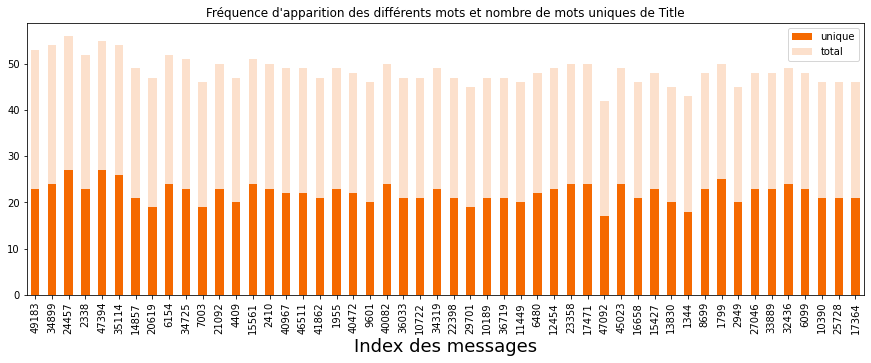

In [ ]:
## Affichage des fréquences et des mots uniques

plt.rcParams["figure.figsize"] = [15, 5]
colors = ["#f56900", "#fce0cc"]
t = 'Fréquence d\'apparition des différents mots et nombre de mots uniques de Title'
df[['unique', 'total']][:50].plot(kind = 'bar', color = colors, title = t, stacked = True)
plt.xlabel('Index des messages', fontsize=18)

## Création de la liste des stopwords

In [ ]:
## Fréquence des mots les plus utilisés

freq_totale = nltk.Counter()

for k, v in corpora.items():
    freq_totale += freq[k]

freq_totale.most_common(145)

[('to', 18906),
 ('in', 15657),
 ('how', 11591),
 ('a', 10600),
 ('the', 7087),
 ('with', 6628),
 ('of', 6161),
 ('is', 5399),
 ('and', 4866),
 ('not', 4723),
 ('on', 4234),
 ('for', 4026),
 ('from', 3767),
 ('using', 3482),
 ('i', 2689),
 ('error', 2554),
 ('an', 2339),
 ('when', 2271),
 ('python', 2116),
 ('android', 1838),
 ('use', 1784),
 ('why', 1774),
 ('file', 1764),
 ('can', 1751),
 ('angular', 1743),
 ('does', 1677),
 ('get', 1570),
 ('do', 1502),
 ('function', 1484),
 ('or', 1450),
 ('c', 1438),
 ('data', 1371),
 ('what', 1312),
 ('java', 1293),
 ('app', 1264),
 ('react', 1238),
 ('array', 1224),
 ('it', 1203),
 ('code', 1103),
 ('multiple', 1067),
 ('type', 1062),
 ('by', 1056),
 ('as', 1052),
 ('list', 993),
 ('value', 987),
 ('after', 983),
 ('object', 969),
 ('class', 946),
 ('core', 939),
 ('string', 929),
 ('between', 926),
 ('api', 912),
 ('find', 911),
 ('studio', 910),
 ('working', 894),
 ('be', 890),
 ('if', 885),
 ('create', 884),
 ('way', 870),
 ('no', 853),
 ('ca

In [ ]:
## Création de la liste des stopwords pour la variable 'Title'

sw = set()
most_freq = list(pd.DataFrame(freq_totale.most_common(145))[0])
default = nltk.corpus.stopwords.words('english')

sw.update(most_freq)
sw.update(tuple(default))
sw

{'2',
 '4',
 'a',
 'about',
 'above',
 'access',
 'add',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'android',
 'angular',
 'another',
 'any',
 'api',
 'app',
 'application',
 'are',
 'aren',
 "aren't",
 'array',
 'as',
 'aspnet',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'build',
 'but',
 'by',
 'c',
 'call',
 'can',
 'cannot',
 'cant',
 'change',
 'check',
 'class',
 'code',
 'column',
 'component',
 'convert',
 'core',
 'couldn',
 "couldn't",
 'create',
 'custom',
 'd',
 'data',
 'dataframe',
 'did',
 'didn',
 "didn't",
 'difference',
 'different',
 'do',
 'docker',
 'does',
 'doesn',
 "doesn't",
 'doesnt',
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'error',
 'failed',
 'few',
 'file',
 'files',
 'find',
 'firebase',
 'flutter',
 'for',
 'found',
 'from',
 'function',
 'further',
 'get',
 'git',
 'google',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'h

In [ ]:
## Récupération des comptages et des fréquences en supprimant les stopwords

freq2, stats2, corpora2 = freq_stats_corpora2()
df2 = pd.DataFrame.from_dict(stats2, orient='index').sort_values(by = 'unique', ascending=False)
df2

,total,unique
27129,16,15
29099,15,15
25551,15,14
2781,14,14
2982,14,14
...,...,...
42002,0,0
25207,0,0
39355,0,0
15817,0,0


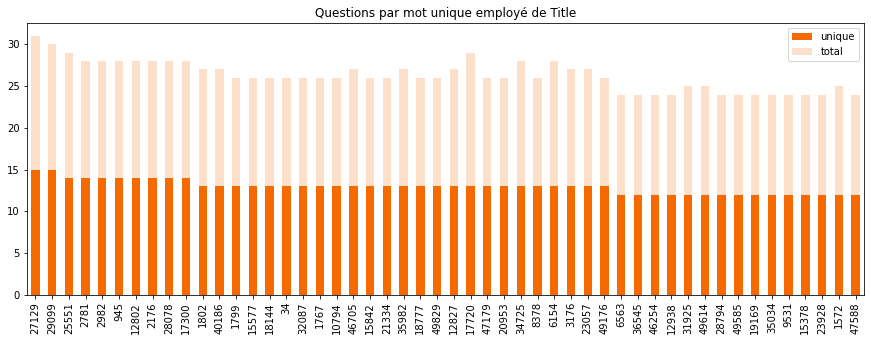

In [ ]:
## Affichage des fréquences et des mots uniques

plt.rcParams["figure.figsize"] = 15, 5
colors = ["#f56900", "#fce0cc"]
t = 'Questions par mot unique employé de Title'
df2[['unique', 'total']][:50].plot(kind = 'bar', color = colors, title = t, stacked = True)

In [ ]:
df_sw_title = pd.DataFrame(sw, columns=['sw_title'])
df_sw_title

,sw_title
0,do
1,doesnt
2,what
3,will
4,ours
...,...
275,further
276,docker
277,of
278,her


In [ ]:
## A partir de Google Colab

df_sw_title.to_csv('stopwords_title.csv', sep = ',', index=False)
files.download('stopwords_title.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Exploration du corpus de textes

### Stemming ou racinisation

In [ ]:
## Stemming sur une question

#tokenizer = nltk.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
tokens = (message.encode().lower().decode('utf-8')).split()
# tokens = tokenizer.tokenize(message.encode().lower().decode('utf-8'))
stemmed_tokens = [stemmer.stem(token) for token in tokens]

stemmed_tokens

['is',
 'there',
 'ani',
 'way',
 'to',
 'read',
 '.docx',
 'file',
 'includ',
 'auto',
 'number',
 'use',
 'python-docx']

In [ ]:
## Récupération des comptages des mots après Stemming

freq3, stats3, corpora3 = freq_stats_corpora3()
df3 = pd.DataFrame.from_dict(stats3, orient='index').sort_values(by = 'unique', ascending=False)
df3

,total,unique
29099,15,15
28078,14,14
2781,14,14
17300,14,14
25551,15,14
...,...,...
18771,0,0
7854,0,0
18864,0,0
7811,0,0


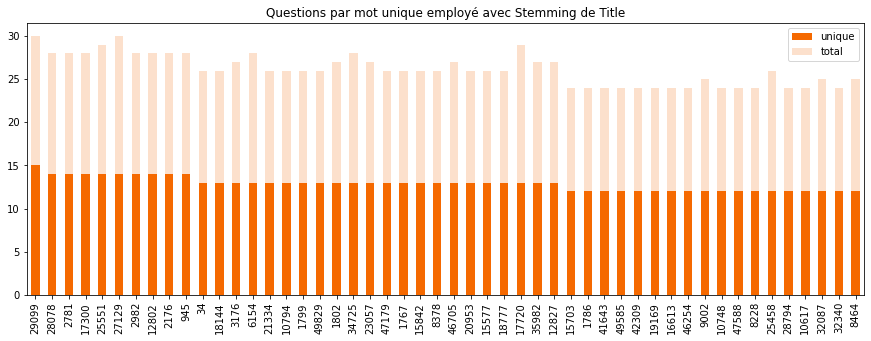

In [ ]:
## Affichage des fréquences et des mots uniques

plt.rcParams["figure.figsize"] = 15, 5
colors = ["#f56900", "#fce0cc"]
t = 'Questions par mot unique employé avec Stemming de Title'
df3[['unique', 'total']][:50].plot(kind = 'bar', color = colors, title = t, stacked = True)

### Lemmatisation

In [ ]:
## Lemmatisation sur une question

#tokenizer = nltk.RegexpTokenizer(r'\w+')

lemmatizer = WordNetLemmatizer()

tokens = (message.encode().lower().decode('utf-8')).split()
# tokens = tokenizer.tokenize(message.encode().lower().decode('utf-8'))
lemmat_tokens = [lemmatizer.lemmatize(token) for token in tokens]

lemmat_tokens

['is',
 'there',
 'any',
 'way',
 'to',
 'read',
 '.docx',
 'file',
 'include',
 'auto',
 'numbering',
 'using',
 'python-docx']

In [ ]:
## Récupération des comptages des mots après Lemmatisation

freq4, stats4, corpora4 = freq_stats_corpora4()
df4 = pd.DataFrame.from_dict(stats4, orient='index').sort_values(by = 'unique', ascending=False)
df4

,total,unique
29099,15,15
27129,16,15
12802,14,14
2982,14,14
25551,15,14
...,...,...
36551,0,0
14739,0,0
27424,0,0
15049,0,0


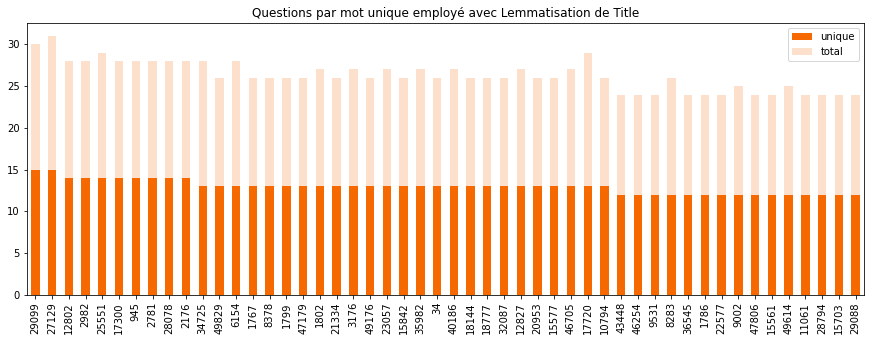

In [ ]:
## Affichage des fréquences et des mots uniques

plt.rcParams["figure.figsize"] = 15, 5
colors = ["#f56900", "#fce0cc"]
t = 'Questions par mot unique employé avec Lemmatisation de Title'
df4[['unique', 'total']][:50].plot(kind = 'bar', color = colors, title = t, stacked = True)

## Nettoyage des messages

In [ ]:
## Nettoyage des données en fonction des différents traitements

data['Title_noms'] = data.apply(lambda row : conservation_noms(row, 'Title'), axis=1)

data['Title_nettoye_sans'] = data.apply(lambda row : nettoyage_sans_traitement(row, 'Title_noms'), axis=1)
data['Title_nettoye_stopwords'] = data.apply(lambda row : nettoyage_stopwords(row, 'Title_noms'), axis=1)
data['Title_nettoye_lem'] = data.apply(lambda row : nettoyage_lemmatisation(row, 'Title_noms'), axis=1)
data['Title_nettoye_stem'] = data.apply(lambda row : nettoyage_stemming(row, 'Title_noms'), axis=1)

data[['Title', 'Title_noms', 'Title_nettoye_sans', 'Title_nettoye_stopwords', 'Title_nettoye_lem', 'Title_nettoye_stem']].head(8)

,Title,Title_noms,Title_nettoye_sans,Title_nettoye_stopwords,Title_nettoye_lem,Title_nettoye_stem
0,Is there any way to read .docx file include au...,way docx file auto pythondocx,way docx file auto pythondocx,docx auto pythondocx,docx auto pythondocx,docx auto pythondocx
1,"With xarray, how to parallelize 1D operations ...",xarray 1d operations dataset,xarray operations dataset,xarray operations dataset,xarray operation dataset,xarray oper dataset
2,Check if prime big-o,prime bigo,prime bigo,prime bigo,prime bigo,prime bigo
3,Meaning of dot in lm(y~.) in R,meaning dot lmy r,meaning dot lmy,meaning dot lmy,meaning dot lmy,mean dot lmi
4,attributeerror: module 'cv2.face' has no attri...,attributeerror module attribute createlbphface...,attributeerror module attribute createlbphface...,attributeerror attribute createlbphfacerecognizer,attributeerror attribute createlbphfacerecognizer,attributeerror attribut createlbphfacerecogn
5,Unmet Peer Dependency popper.js,peer dependency popperjs,peer dependency popperjs,peer dependency popperjs,peer dependency popperjs,peer depend popperj
6,Dynamically integrate Vuetify v-stepper with V...,vuetify vstepper vue router,vuetify vstepper vue router,vuetify vstepper vue router,vuetify vstepper vue router,vuetifi vstepper vue router
7,"Why does the PHP parser understand ""$x++-++$x""...",php parser xx,php parser xx,php parser xx,php parser xx,php parser xx


In [ ]:
data[['Title_nettoye_sans', 'Title_nettoye_stopwords', 'Title_nettoye_lem', 'Title_nettoye_stem']].isnull().sum()

Title_nettoye_sans         0
Title_nettoye_stopwords    0
Title_nettoye_lem          0
Title_nettoye_stem         0
dtype: int64

In [ ]:
print('Message initial : ')
print(data['Title'][1])
print('-------------------------------------------------------------------------------------')
print('Message sans traitement : ')
print(data['Title_nettoye_sans'][1])
print('-------------------------------------------------------------------------------------')
print('Message sans les stopwords : ')
print(data['Title_nettoye_stopwords'][1])
print('-------------------------------------------------------------------------------------')
print('Message après lematisation : ')
print(data['Title_nettoye_lem'][1])
print('-------------------------------------------------------------------------------------')
print('Message après stemming : ')
print(data['Title_nettoye_stem'][1])

Message initial : 
With xarray, how to parallelize 1D operations on a multidimensional Dataset?
-------------------------------------------------------------------------------------
Message sans traitement : 
xarray operations dataset
-------------------------------------------------------------------------------------
Message sans les stopwords : 
xarray operations dataset
-------------------------------------------------------------------------------------
Message après lematisation : 
xarray operation dataset
-------------------------------------------------------------------------------------
Message après stemming : 
xarray oper dataset


In [ ]:
## Suppression des messages vides

data = data[data['Title_nettoye_sans'] != '']
data = data[data['Title_nettoye_stopwords'] != '']
data = data[data['Title_nettoye_lem'] != '']
data = data[data['Title_nettoye_stem'] != '']

In [ ]:
data.reset_index(inplace = True)

In [ ]:
# data.drop('index', axis=1, inplace=True)

# Prétraitement : Nettoyage des tags Stack Overflow avec la variable 'Tags'

## Nettoyage des Tags

In [ ]:
data['Tags']

0                             <python><docx><python-docx>
1                           <python><dask><python-xarray>
2                     <c++><big-o><asymptotic-complexity>
3                                                     <r>
4         <python><python-3.x><opencv3.0><opencv-contrib>
                               ...                       
48442          <ios><swift><ios13><xcode11><ios-darkmode>
48443                    <android><reactjs><react-native>
48444                     <javascript><jquery><html><css>
48445    <c#><.net><apple-push-notifications><token><jwt>
48446           <python-3.x><python-requests><eventbrite>
Name: Tags, Length: 48447, dtype: object

In [ ]:
tags = data['Tags'][1]
tags

'<python><dask><python-xarray>'

In [ ]:
## Création d'une liste de tags

tags_new = re.sub('<',"", data['Tags'][1])
tags_new = re.sub('>', ' ', tags_new)
tags_new = tags_new[:-1]
tags_new.split()

['python', 'dask', 'python-xarray']

In [ ]:
## Nettoyage des Tags Stack Overflow

data['Tags_new'] = data.apply(lambda row : nettoyage_tags(row), axis=1)
data[['Tags', 'Tags_new']]

,Tags,Tags_new
0,<python><docx><python-docx>,python docx python-docx
1,<python><dask><python-xarray>,python dask python-xarray
2,<c++><big-o><asymptotic-complexity>,c++ big-o asymptotic-complexity
3,<r>,r
4,<python><python-3.x><opencv3.0><opencv-contrib>,python python-3.x opencv3.0 opencv-contrib
...,...,...
48442,<ios><swift><ios13><xcode11><ios-darkmode>,ios swift ios13 xcode11 ios-darkmode
48443,<android><reactjs><react-native>,android reactjs react-native
48444,<javascript><jquery><html><css>,javascript jquery html css
48445,<c#><.net><apple-push-notifications><token><jwt>,c# .net apple-push-notifications token jwt


Text(0.5, 1.0, 'Nombre de Tags par message')

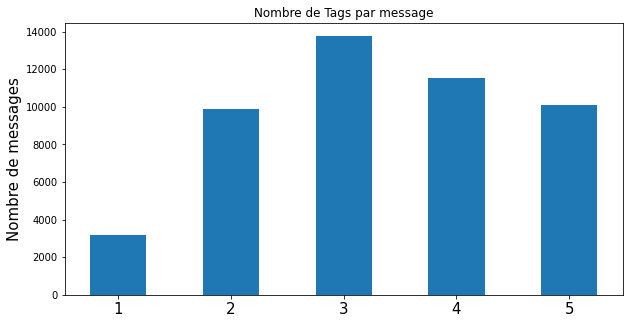

In [ ]:
## Histogramme du Nombre de Tags dans les messages

data['Nombre_Tags'] = data.apply(lambda row: len(row['Tags_new'].split()), axis=1)
data['Nombre_Tags'] = np.where(data['Nombre_Tags'] == '', 0, data['Nombre_Tags'])

plt.figure(figsize=(10, 5))

plt.hist(data['Nombre_Tags'], bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.5)
plt.xticks(fontsize=15)
plt.ylabel("Nombre de messages", fontsize=15)
plt.title('Nombre de Tags par message')

In [ ]:
## Fréquence d'apparitions chaque Tag Stack Overflow

tags_tot = data['Tags_new'].str.cat(sep=' ')
words = tags_tot.split()
Word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(Word_dist.most_common(),columns=['Tags', 'Frequency'])
rslt['Freq_cumulee'] = rslt["Frequency"].cumsum()
rslt

,Tags,Frequency,Freq_cumulee
0,python,6328,6328
1,javascript,5087,11415
2,java,4231,15646
3,android,4143,19789
4,angular,2590,22379
...,...,...,...
12360,adyen,1,160702
12361,unstated,1,160703
12362,gulp-mocha,1,160704
12363,peer-dependencies,1,160705


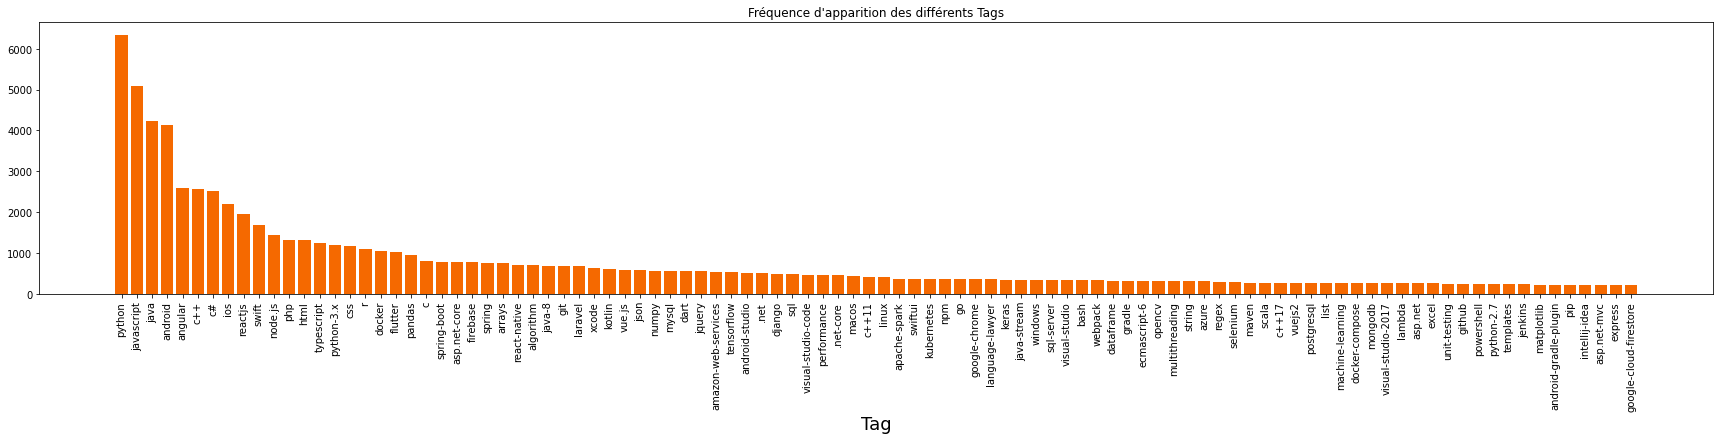

In [ ]:
## Affichage des fréquences d'apparition du Top 100 des Tags  

plt.rcParams["figure.figsize"] = [30, 5]
plt.bar('Tags', 'Frequency', data=rslt[:100], color=["#f56900"])
plt.xlabel('Tag', fontsize=18)
plt.xticks(rotation=90)
plt.title('Fréquence d\'apparition des différents Tags')
plt.show()

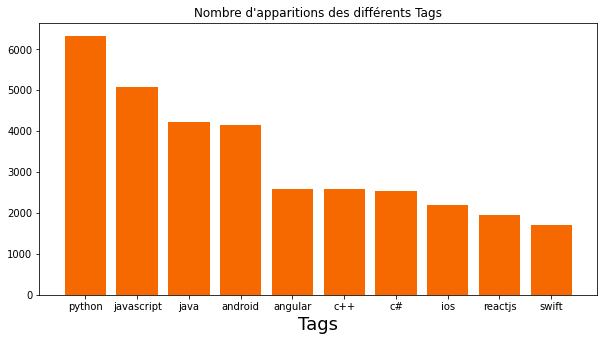

In [ ]:
## Affichage des fréquences des 10 Tags les plus fréquents

plt.rcParams["figure.figsize"] = [10, 5]
plt.bar('Tags', 'Frequency', data=rslt[:10], color=["#f56900"])
plt.xlabel('Tags', fontsize=18)
plt.title('Nombre d\'apparitions des différents Tags')
plt.show()

In [ ]:
print('Il y a', rslt[rslt['Frequency'] == 1].shape[0], 'Tags apparaissant une seule fois.')

Il y a 5439 Tags apparaissant une seule fois.


## Sélection des Tags intéressants

In [ ]:
## Pourcentage d'apparition de chaque Tag dans tous les messages

rslt['Pourcentage_cumule'] = rslt['Freq_cumulee']*100/rslt['Frequency'].sum()
rslt

,Tags,Frequency,Freq_cumulee,Pourcentage_cumule
0,python,6328,6328,3.937625
1,javascript,5087,11415,7.103033
2,java,4231,15646,9.735791
3,android,4143,19789,12.313790
4,angular,2590,22379,13.925429
...,...,...,...,...
12360,adyen,1,160702,99.997511
12361,unstated,1,160703,99.998133
12362,gulp-mocha,1,160704,99.998755
12363,peer-dependencies,1,160705,99.999378


Il est possible de garder uniquement 90% des Tags utilisés dans les messages.

In [ ]:
## Récupération des 100 Tags les utilisés

rslt.iloc[0:100]

,Tags,Frequency,Freq_cumulee,Pourcentage_cumule
0,python,6328,6328,3.937625
1,javascript,5087,11415,7.103033
2,java,4231,15646,9.735791
3,android,4143,19789,12.313790
4,angular,2590,22379,13.925429
...,...,...,...,...
95,pip,224,77307,48.104613
96,intellij-idea,220,77527,48.241509
97,asp.net-mvc,217,77744,48.376539
98,express,216,77960,48.510945


In [ ]:
liste_Tags_selectionne = list(rslt.iloc[0:100]['Tags'])

In [ ]:
## Nettoyage des Tags en supprimant les Tags les moins fréquents

data['Tags_nettoyes'] = data.apply(lambda row : conservation_mots_frequents(row, liste_Tags_selectionne, 'Tags_new'), axis=1)
data.head(8)

,index,Body,Title,Tags,Body_new,Body_noms,Body_nettoye_sans,Body_nettoye_stopwords,Body_nettoye_lem,Body_nettoye_stem,Title_noms,Title_nettoye_sans,Title_nettoye_stopwords,Title_nettoye_lem,Title_nettoye_stem,Tags_new,Nombre_Tags,Tags_nettoyes
0,0,<p>Problem statement: Extract sections from .d...,Is there any way to read .docx file include au...,<python><docx><python-docx>,Problem statement: Extract sections from .docx...,problem statement extract sections docx file a...,problem statement extract sections docx file a...,statement extract sections docx autonumbering ...,statement extract section docx autonumbering p...,statement extract section docx autonumb python...,way docx file auto pythondocx,way docx file auto pythondocx,docx auto pythondocx,docx auto pythondocx,docx auto pythondocx,python docx python-docx,3,python
1,1,<p>I have a 4D xarray Dataset. I want to carry...,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>,I have a 4D xarray Dataset. I want to carry ou...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variable dimension r...,xarray dataset regress variabl dimens regress ...,xarray 1d operations dataset,xarray operations dataset,xarray operations dataset,xarray operation dataset,xarray oper dataset,python dask python-xarray,3,python
2,2,<p>My original function to determine if a numb...,Check if prime big-o,<c++><big-o><asymptotic-complexity>,My original function to determine if a number ...,function number complexity optimizations check...,function number complexity optimizations check...,number complexity optimizations check bigo pro...,number complexity optimization check bigo prog...,number complex optim check bigo program fact,prime bigo,prime bigo,prime bigo,prime bigo,prime bigo,c++ big-o asymptotic-complexity,3,c++
3,3,<p>I am trying to understand the meaning of th...,Meaning of dot in lm(y~.) in R,<r>,I am trying to understand the meaning of this ...,meaning statement r code r help section interp...,meaning statement code help section interpreta...,meaning statement section interpretations form...,meaning statement section interpretation formu...,mean statement section interpret formula conte...,meaning dot lmy r,meaning dot lmy,meaning dot lmy,meaning dot lmy,mean dot lmi,r,1,r
4,4,<p>So i'm doing a little personal project but ...,attributeerror: module 'cv2.face' has no attri...,<python><python-3.x><opencv3.0><opencv-contrib>,So i'm doing a little personal project but i k...,project error recognizer opencvcontrib code li...,project error recognizer opencvcontrib code li...,recognizer opencvcontrib line modules thing la...,recognizer opencvcontrib line module thing lap...,recogn opencvcontrib line modul thing laptop d...,attributeerror module attribute createlbphface...,attributeerror module attribute createlbphface...,attributeerror attribute createlbphfacerecognizer,attributeerror attribute createlbphfacerecognizer,attributeerror attribut createlbphfacerecogn,python python-3.x opencv3.0 opencv-contrib,4,"python, python-3.x"
5,5,<p>I'm having trouble using some ng-bootstrap ...,Unmet Peer Dependency popper.js,<jquery><npm>,I'm having trouble using some ng-bootstrap dro...,trouble ngbootstrap dropdown component depende...,trouble ngbootstrap dropdown component depende...,trouble ngbootstrap dropdown component depende...,trouble ngbootstrap dropdown component depende...,troubl ngbootstrap dropdown compon depend jque...,peer dependency popperjs,peer dependency popperjs,peer dependency popperjs,peer dependency popperjs,peer depend popperj,jquery npm,2,"jquery, npm"
6,6,<p>I would like to integrate vuetify's <a href...,Dynamically integrate Vuetify v-stepper with V...,<javascript><vue.js><vue-router><vuetify.js><v...,I would like to integrate vuetify's v-stepper ...,vuetifys vstepper vue router requirements step...,vuetifys vstepper vue router requi

In [ ]:
## Fréquence d'apparition des Tags après nettoyage

tags_tot = data['Tags_nettoyes'].str.cat(sep=' ')
words = tags_tot.split()
Word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(Word_dist.most_common(),columns=['Tags', 'Frequency'])
rslt['Freq_cumulee'] = rslt["Frequency"].cumsum()
rslt['Pourcentage_cumule'] = rslt['Freq_cumulee']*100/rslt['Frequency'].sum()
rslt

,Tags,Frequency,Freq_cumulee,Pourcentage_cumule
0,"python,",4423,4423,5.657819
1,"javascript,",4026,8449,10.807803
2,"java,",3024,11473,14.676047
3,android,2519,13992,17.898305
4,python,1905,15897,20.335146
...,...,...,...,...
192,"visual-studio-2017,",5,78169,99.992325
193,"android-gradle-plugin,",3,78172,99.996162
194,"docker-compose,",1,78173,99.997442
195,"java-stream,",1,78174,99.998721


Text(0.5, 1.0, 'Nombre de Tags par message')

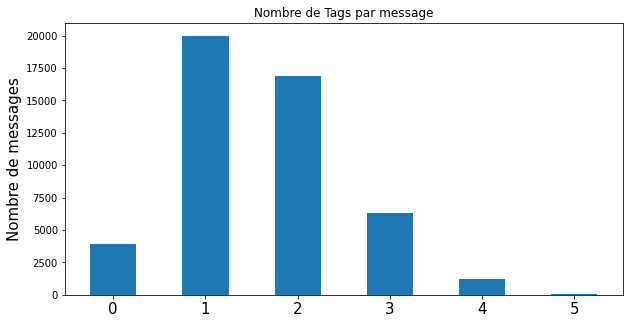

In [ ]:
## Histogramme du nombre de Tags dans les messsages après nettoyage

data['Nombre_Tags_nettoyes'] = data.apply(lambda row: len(row['Tags_nettoyes'].split()), axis=1)
data['Nombre_Tags_nettoyes'] = np.where(data['Tags_nettoyes'] == '', 0, data['Nombre_Tags_nettoyes'])

plt.figure(figsize=(10, 5))

plt.hist(data['Nombre_Tags_nettoyes'], bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.5)
plt.xticks(fontsize=15)
plt.ylabel("Nombre de messages", fontsize=15)
plt.title('Nombre de Tags par message')

# Approche non supervisée : Transformez des données textuelles de la variable 'Body' en features

## Création des features de la variable 'Body' avec la méthode LDA

In [ ]:
## Définition des paramètres du modèle

search_params = {'n_components': [25, 50, 75, 100], 'learning_decay': [0.5, 0.8], 'max_iter' : [5], 'learning_offset' : [50], 'learning_method' : ['online'], 'n_jobs' : [-1], 'max_iter' : [5], 'random_state' : [0]}
lda = LatentDirichletAllocation()
no_top_words = 10

### Sans traitement

In [ ]:
## Création des vecteurs de mots

tf_vectorizer = CountVectorizer(min_df = 2, max_features = 1000)
data_vectorized_sans = tf_vectorizer.fit_transform(data['Body_nettoye_sans'])

In [ ]:
## Validation croisée

model_sans = GridSearchCV(lda, param_grid=search_params)
model_sans.fit(data_vectorized_sans)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
## Evaluation du modèle

best_lda_model_sans = model_sans.best_estimator_
display_topics(best_lda_model_sans, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
test code time memory loop tests seconds stream program performance
Topic 1:
file files folder path directory template csv name code way
Topic 2:
question number example string way case answer problem time difference
Topic 3:
python lines variables php tag framework css target style people
Topic 4:
text button line code view screen content height problem position
Topic 5:
api request web response user core firebase requests access authentication
Topic 6:
data database model query user table sql db email entity
Topic 7:
column table row columns rows date items dataframe statement group
Topic 8:
service spring controller application url view configuration config boot notification
Topic 9:
page component form html state react event components parent way
Topic 10:
background header color bar search navigation code tab branch activity
Topic 11:
command docker container windows environment git machine commands host process
Topic 12:
value values exception key index step keys block c

### Stopwords

In [ ]:
## Création des vecteurs de mots

tf_vectorizer = CountVectorizer(min_df = 2, max_features = 1000)
data_vectorized_stopwords = tf_vectorizer.fit_transform(data['Body_nettoye_stopwords'])

In [ ]:
## Validation croisée

model_stopwords = GridSearchCV(lda, param_grid=search_params)
model_stopwords.fit(data_vectorized_stopwords)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
## Evaluation du modèle

best_lda_model_stopwords = model_stopwords.best_estimator_
display_topics(best_lda_model_stopwords, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
java values column methods classes dataframe interface names vector kotlin
Topic 1:
component result form field components item fields parent group child
Topic 2:
number size memory numbers video points frame title seconds mb
Topic 3:
ios background color bar layout search top xml cell icon
Topic 4:
name changes lines sql document box control tutorial click node
Topic 5:
test answer property tests case lot properties stream difference solutions
Topic 6:
thanks text button program advance thread process algorithm threads cpu
Topic 7:
android google studio device window php email sdk gradle apps
Topic 8:
exception loop spring module location npm dependency dependencies modules boot
Topic 9:
view model custom date plugin navigation height attribute position header
Topic 10:
state content react context statement url operation console section design
Topic 11:
json response xcode controller mode framework parameter target stack headers
Topic 12:
reference compiler task types behavio

### Lemmatisation

In [ ]:
## Création des vecteurs de mots

tf_vectorizer = CountVectorizer(min_df = 2, max_features = 1000)
data_vectorized_lem = tf_vectorizer.fit_transform(data['Body_nettoye_lem'])

In [ ]:
## Validation croisée

model_lem = GridSearchCV(lda, param_grid=search_params)
model_lem.fit(data_vectorized_lem)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
## Evaluation du modèle

best_lda_model_lem = model_lem.best_estimator_
display_topics(best_lda_model_lem, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
column table row value index statement dataframe number record result
Topic 1:
database query sql email db certificate table domain graph django
Topic 2:
point function thread template end entry time logic csv account
Topic 3:
array element event javascript reference return warning attribute box rule
Topic 4:
string item html parameter tag cs document group structure operator
Topic 5:
test result operation approach stream performance second case plugin check
Topic 6:
loop answer repository stack tutorial unit instruction article label flag
Topic 7:
library program documentation map activity vector product source language byte
Topic 8:
service page web url core connection api request client route
Topic 9:
image line name word firebase pointer notification integer style address
Topic 10:
request exception response json header spring api post xcode client
Topic 11:
property field state object entity react context branch widget change
Topic 12:
step difference size git mode root c

### Stemming

In [ ]:
## Création des vecteurs de mots

tf_vectorizer = CountVectorizer(min_df = 2, max_features = 1000)
data_vectorized_stem = tf_vectorizer.fit_transform(data['Body_nettoye_stem'])

In [ ]:
## Validation croisée

model_stem = GridSearchCV(lda, param_grid=search_params)
model_stem.fit(data_vectorized_stem)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
## Evaluation du modèle

best_lda_model_stem = model_stem.best_estimator_
display_topics(best_lda_model_stem, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
column valu variabl row number datafram date index group algorithm
Topic 1:
page script content machin git github repositori chang certif height
Topic 2:
string name number word charact address format pipelin packag width
Topic 3:
input refer error css return style attribut compil snippet icon
Topic 4:
devic day store android cach activ app filter anim year
Topic 5:
servic log connect url configur stream node locat instanc setup
Topic 6:
model method featur record cell length django train kera integ
Topic 7:
thread permiss js directori second ui nodej widget config minut
Topic 8:
custom paramet templat argument access layout password fragment account function
Topic 9:
python folder key xcode statement context block structur import pod
Topic 10:
java field default constructor pointer spring type express lambda member
Topic 11:
compon array element button event form state react map parent
Topic 12:
thank io except background color advanc answer bar post stack
Topic 13:
size mode

### Comparaison des résultats

In [ ]:
## Comparaison des résultats

df = pd.DataFrame(columns = ['Méthode nettoyage', 'Hyperparamètres optimaux', 'Log Likelihood Score', 'Perplexity'])
df.loc[0] = ['Sans traitement', model_sans.best_params_, model_sans.best_score_, best_lda_model_sans.perplexity(data_vectorized_sans)]
df.loc[1] = ['Stopwords', model_stopwords.best_params_, model_stopwords.best_score_, best_lda_model_stopwords.perplexity(data_vectorized_stopwords)]
df.loc[2] = ['Lemmatisation', model_lem.best_params_, model_lem.best_score_, best_lda_model_lem.perplexity(data_vectorized_lem)]
df.loc[3] = ['Stemming', model_stem.best_params_, model_stem.best_score_, best_lda_model_stem.perplexity(data_vectorized_stem)]
df

,Méthode nettoyage,Hyperparamètres optimaux,Log Likelihood Score,Perplexity
0,Sans traitement,"{'learning_decay': 0.8, 'learning_method': 'on...",-1.184325e+06,434.154302
1,Stopwords,"{'learning_decay': 0.8, 'learning_method': 'on...",-9.308151e+05,591.465160
2,Lemmatisation,"{'learning_decay': 0.8, 'learning_method': 'on...",-9.763752e+05,512.209616
3,Stemming,"{'learning_decay': 0.8, 'learning_method': 'on...",-1.004038e+06,527.051977


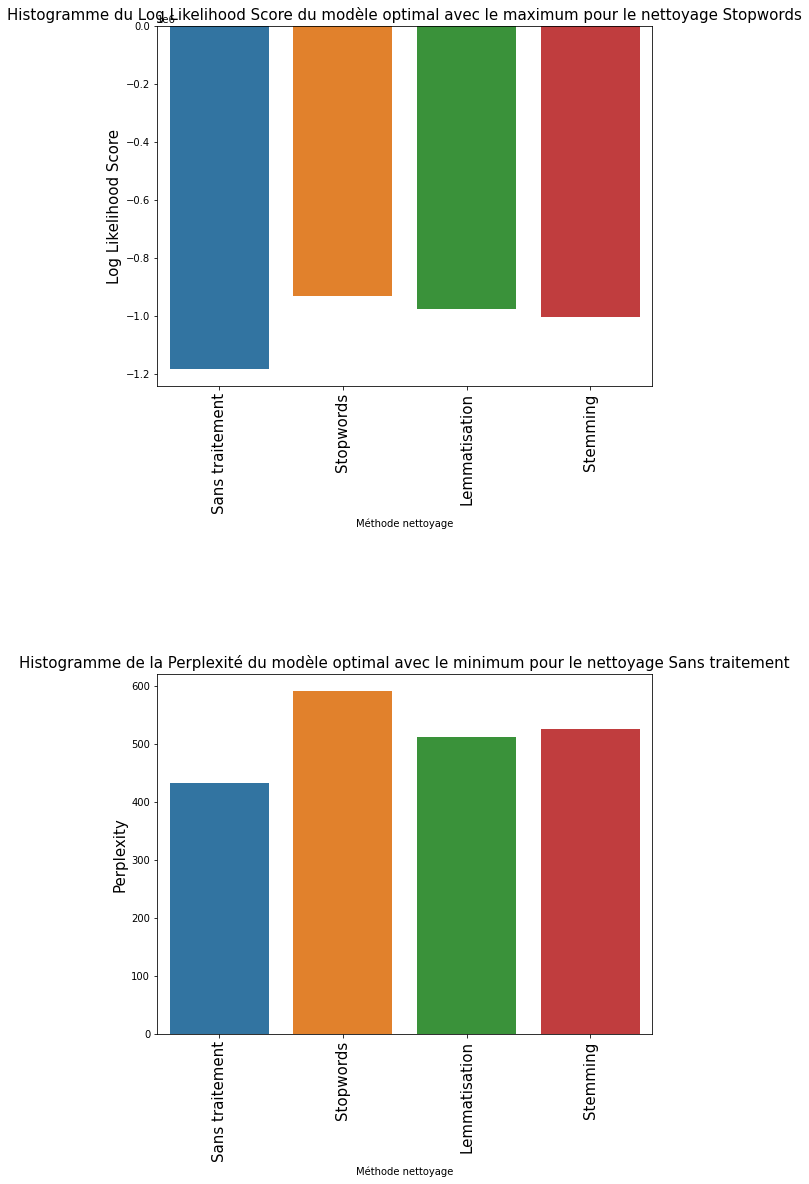

In [ ]:
plt.figure(figsize=(5, 20))

plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.2, hspace = 0.8)

plt.subplot(2,1,1)
sns.barplot(x=df['Méthode nettoyage'],y=df['Log Likelihood Score'])
plt.xticks(fontsize=15, rotation=90)
plt.ylabel("Log Likelihood Score", fontsize=15)
plt.title('Histogramme du Log Likelihood Score du modèle optimal avec le maximum pour le nettoyage {}'.format(df['Méthode nettoyage'][df['Log Likelihood Score'] == df['Log Likelihood Score'].max()].values[0]), fontsize=15)

plt.subplot(2,1,2)
sns.barplot(x=df['Méthode nettoyage'],y=df['Perplexity'])
plt.xticks(fontsize=15, rotation=90)
plt.ylabel("Perplexity", fontsize=15)
plt.title('Histogramme de la Perplexité du modèle optimal avec le minimum pour le nettoyage {}'.format(df['Méthode nettoyage'][df['Perplexity'] == df['Perplexity'].min()].values[0]), fontsize=15)

plt.show()

## Sélection du modèle

In [ ]:
## Sélection du modèle

best_lda_model = best_lda_model_stopwords
data_vectorized = data_vectorized_stopwords
variable = 'Body_nettoye_stopwords'

## Création du DataFrame du poids de chaque Topic

lda_output = best_lda_model.transform(data_vectorized)
topicnames = ["Topic_Body_" + str(i) for i in range(best_lda_model.n_components)]
docnames = [str(i) for i in range(len(data))]
df_document_topic_body = pd.DataFrame(np.round(lda_output, 2), columns = topicnames, index = docnames)

## Topic dominant pour chaque message

dominant_topic_body = np.argmax(df_document_topic_body.values, axis=1)
df_document_topic_body['dominant_topic_Body'] = dominant_topic_body

df_document_topic_body

,Topic_Body_0,Topic_Body_1,Topic_Body_2,Topic_Body_3,Topic_Body_4,Topic_Body_5,Topic_Body_6,Topic_Body_7,Topic_Body_8,Topic_Body_9,Topic_Body_10,Topic_Body_11,Topic_Body_12,Topic_Body_13,Topic_Body_14,Topic_Body_15,Topic_Body_16,Topic_Body_17,Topic_Body_18,Topic_Body_19,Topic_Body_20,Topic_Body_21,Topic_Body_22,Topic_Body_23,Topic_Body_24,dominant_topic_Body
0,0.01,0.01,0.01,0.01,0.01,0.01,0.35,0.01,0.01,0.01,0.35,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,6
1,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.08,0.00,18
2,0.01,0.01,0.20,0.01,0.01,0.22,0.17,0.01,0.01,0.27,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,9
3,0.00,0.00,0.04,0.00,0.04,0.00,0.00,0.00,0.00,0.04,0.75,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,10
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48442,0.07,0.00,0.00,0.16,0.00,0.00,0.00,0.20,0.00,0.03,0.00,0.21,0.00,0.05,0.00,0.13,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,11
48443,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.19,0.01,0.01,0.16,0.01,0.01,0.01,0.15,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.39,24
48444,0.01,0.01,0.01,0.49,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.14,0.01,0.01,0.01,0.01,0.01,0.25,0.01,0.01,3
48445,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.19,0.00,0.00,0.39,0.00,0.00,0.00,0.00,0.21,19


In [ ]:
## Nombre de messages pour chaque Topic

df_topic_distribution = df_document_topic_body['dominant_topic_Body'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,19,3355
1,18,3229
2,13,3221
3,7,3092
4,12,3004
5,5,2854
6,20,2689
7,23,2557
8,0,2149
9,9,1942


In [ ]:
## Topic dominat de chaque message

data['dominant_topic_Body'] = list(df_document_topic_body['dominant_topic_Body'])

In [ ]:
## Top 20 des mots de chaque topic

NB_top_mots = 20
topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=best_lda_model, n_words=NB_top_mots)        
topic_keywords = pd.DataFrame(topic_keywords)
topic_keywords.columns = ['Word '+str(i) for i in range(topic_keywords.shape[1])]
topic_keywords.index = ['Topic_Body_'+str(i) for i in range(topic_keywords.shape[0])]
topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic_Body_0,java,values,column,methods,classes,dataframe,interface,names,vector,kotlin,fragment,pandas,editor,dataset,bash,distribution,activity,fragments,interfaces,features
Topic_Body_1,component,result,form,field,components,item,fields,parent,group,child,network,entity,forms,engine,ip,children,internet,level,case,property
Topic_Body_2,number,size,memory,numbers,video,points,frame,title,seconds,mb,times,gb,users,limit,amount,intellij,max,count,ram,minutes
Topic_Body_3,ios,background,color,bar,layout,search,top,xml,cell,icon,bottom,apple,environment,macos,grid,buttons,iphone,bug,text,button
Topic_Body_4,name,changes,lines,sql,document,box,control,tutorial,click,node,nodes,line,packages,plot,flutter,series,card,procedure,days,documents
Topic_Body_5,test,answer,property,tests,case,lot,properties,stream,difference,solutions,answers,approach,questions,branch,cases,unit,integer,check,stackoverflow,posts
Topic_Body_6,thanks,text,button,program,advance,thread,process,algorithm,threads,cpu,pdf,lot,article,idea,ms,report,part,print,game,answer
Topic_Body_7,android,google,studio,device,window,php,email,sdk,gradle,apps,option,devices,message,developer,console,build,tools,emulator,graph,log
Topic_Body_8,exception,loop,spring,module,location,npm,dependency,dependencies,modules,boot,execution,release,install,support,promise,buffer,eclipse,jar,loops,configuration
Topic_Body_9,view,model,custom,date,plugin,navigation,height,attribute,position,header,filter,ideas,views,animation,options,models,width,training,loss,label


In [ ]:
## Création du dictionnaire du Top 20 de mots de chaque Topic

dict_topics_body = {}

for i in range(topic_keywords.shape[0]):
  dict_topics_body[i] = list(topic_keywords.iloc[i])

In [ ]:
## Création de la liste des mots de tous les Topics

liste_globale = []

for i in range(topic_keywords.shape[0]):
  liste_globale = liste_globale + list(topic_keywords.iloc[i])

In [ ]:
## Création de la liste de mots du Topic dominant

data['Liste_Features_Topic_dominant_Body'] = dominant_topic_body
data['Liste_Features_Topic_dominant_Body'] = data['Liste_Features_Topic_dominant_Body'].map(dict_topics_body)
data

,index,Body,Title,Tags,Body_new,Body_noms,Body_nettoye_sans,Body_nettoye_stopwords,Body_nettoye_lem,Body_nettoye_stem,Title_noms,Title_nettoye_sans,Title_nettoye_stopwords,Title_nettoye_lem,Title_nettoye_stem,Tags_new,Nombre_Tags,Tags_nettoyes,Nombre_Tags_nettoyes,Tags_nettoyes_liste,dominant_topic_Body,Liste_Features_Topic_dominant_Body
0,0,<p>Problem statement: Extract sections from .d...,Is there any way to read .docx file include au...,<python><docx><python-docx>,Problem statement: Extract sections from .docx...,problem statement extract sections docx file a...,problem statement extract sections docx file a...,statement extract sections docx autonumbering ...,statement extract section docx autonumbering p...,statement extract section docx autonumb python...,way docx file auto pythondocx,way docx file auto pythondocx,docx auto pythondocx,docx auto pythondocx,docx auto pythondocx,python docx python-docx,3,python,1,[python],6,"[thanks, text, button, program, advance, threa..."
1,1,<p>I have a 4D xarray Dataset. I want to carry...,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>,I have a 4D xarray Dataset. I want to carry ou...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variable dimension r...,xarray dataset regress variabl dimens regress ...,xarray 1d operations dataset,xarray operations dataset,xarray operations dataset,xarray operation dataset,xarray oper dataset,python dask python-xarray,3,python,1,[python],18,"[python, variable, functions, variables, order..."
2,2,<p>My original function to determine if a numb...,Check if prime big-o,<c++><big-o><asymptotic-complexity>,My original function to determine if a number ...,function number complexity optimizations check...,function number complexity optimizations check...,number complexity optimizations check bigo pro...,number complexity optimization check bigo prog...,number complex optim check bigo program fact,prime bigo,prime bigo,prime bigo,prime bigo,prime bigo,c++ big-o asymptotic-complexity,3,c++,1,[c++],9,"[view, model, custom, date, plugin, navigation..."
3,3,<p>I am trying to understand the meaning of th...,Meaning of dot in lm(y~.) in R,<r>,I am trying to understand the meaning of this ...,meaning statement r code r help section interp...,meaning statement code help section interpreta...,meaning statement section interpretations form...,meaning statement section interpretation formu...,mean statement section interpret formula conte...,meaning dot lmy r,meaning dot lmy,meaning dot lmy,meaning dot lmy,mean dot lmi,r,1,r,1,[r],10,"[state, content, react, context, statement, ur..."
4,4,<p>So i'm doing a little personal project but ...,attributeerror: module 'cv2.face' has no attri...,<python><python-3.x><opencv3.0><opencv-contrib>,So i'm doing a little personal project but i k...,project error recognizer opencvcontrib code li...,project error recognizer opencvcontrib code li...,recognizer opencvcontrib line modules thing la...,recognizer opencvcontrib line module thing lap...,recogn opencvcontrib line modul thing laptop d...,attributeerror module attribute createlbphface...,attributeerror module attribute createlbphface...,attributeerror attribute createlbphfacerecognizer,attributeerror attribute createlbphfacerecognizer,attributeerror attribut createlbphfacerecogn,python python-3.x opencv3.0 opencv-contrib,4,"python, python-3.x",2,"[python, python-3.x]",8,"[exception, loop, spring, module, location, np..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48442,49860,<p>So ... I've tried to set my app to disable ...,Why doesn't my iOS app disable dark mode?,<ios><swift><ios13><xcode11><ios-darkmode>,So ... I've tried to set my app to disable iOS...,app ios mode mode apple documentation emulator...,app ios mode mode apple documentation emulator...,ios mode mode app

In [ ]:
## Création de la liste de features dominantes ie match entre les mots contenus dans le message et les mots du Topic dominant

data['match_Topic_dominant_Body'] = data.apply(lambda row : match_topic_dominant_message(row, variable, row['Liste_Features_Topic_dominant_Body']), axis=1)

In [ ]:
## Création de la liste de features globales ie match entre les mots contenus dans le message et des mots de tous les Topics

data['match_Topic_global_Body'] = data.apply(lambda row : match_topic_dominant_message(row, variable, liste_globale), axis=1)

In [ ]:
data['Nombre_mots_Body'] = data.apply(lambda row: len(row[variable].split()), axis=1)
data

,index,Body,Title,Tags,Body_new,Body_noms,Body_nettoye_sans,Body_nettoye_stopwords,Body_nettoye_lem,Body_nettoye_stem,Title_noms,Title_nettoye_sans,Title_nettoye_stopwords,Title_nettoye_lem,Title_nettoye_stem,Tags_new,Nombre_Tags,Tags_nettoyes,Nombre_Tags_nettoyes,Tags_nettoyes_liste,dominant_topic_Body,Liste_Features_Topic_dominant_Body,match_Topic_dominant_Body,match_Topic_global_Body,Nombre_mots_Body
0,0,<p>Problem statement: Extract sections from .d...,Is there any way to read .docx file include au...,<python><docx><python-docx>,Problem statement: Extract sections from .docx...,problem statement extract sections docx file a...,problem statement extract sections docx file a...,statement extract sections docx autonumbering ...,statement extract section docx autonumbering p...,statement extract section docx autonumb python...,way docx file auto pythondocx,way docx file auto pythondocx,docx auto pythondocx,docx auto pythondocx,docx auto pythondocx,python docx python-docx,3,python,1,[python],6,"[thanks, text, button, program, advance, threa...",[text],"[statement, text]",9
1,1,<p>I have a 4D xarray Dataset. I want to carry...,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>,I have a 4D xarray Dataset. I want to carry ou...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variable dimension r...,xarray dataset regress variabl dimens regress ...,xarray 1d operations dataset,xarray operations dataset,xarray operations dataset,xarray operation dataset,xarray oper dataset,python dask python-xarray,3,python,1,[python],18,"[python, variable, functions, variables, order...","[parameters, python, variables]","[dataset, array, questions, results, variables...",26
2,2,<p>My original function to determine if a numb...,Check if prime big-o,<c++><big-o><asymptotic-complexity>,My original function to determine if a number ...,function number complexity optimizations check...,function number complexity optimizations check...,number complexity optimizations check bigo pro...,number complexity optimization check bigo prog...,number complex optim check bigo program fact,prime bigo,prime bigo,prime bigo,prime bigo,prime bigo,c++ big-o asymptotic-complexity,3,c++,1,[c++],9,"[view, model, custom, date, plugin, navigation...",[],"[program, check, number]",7
3,3,<p>I am trying to understand the meaning of th...,Meaning of dot in lm(y~.) in R,<r>,I am trying to understand the meaning of this ...,meaning statement r code r help section interp...,meaning statement code help section interpreta...,meaning statement section interpretations form...,meaning statement section interpretation formu...,mean statement section interpret formula conte...,meaning dot lmy r,meaning dot lmy,meaning dot lmy,meaning dot lmy,mean dot lmi,r,1,r,1,[r],10,"[state, content, react, context, statement, ur...","[statements, section, statement, argument, con...","[part, columns, functions, section, variables,...",27
4,4,<p>So i'm doing a little personal project but ...,attributeerror: module 'cv2.face' has no attri...,<python><python-3.x><opencv3.0><opencv-contrib>,So i'm doing a little personal project but i k...,project error recognizer opencvcontrib code li...,project error recognizer opencvcontrib code li...,recognizer opencvcontrib line modules thing la...,recognizer opencvcontrib line module thing lap...,recogn opencvcontrib line modul thing laptop d...,attributeerror module attribute createlbphface...,attributeerror module attribute createlbphface...,attributeerror attribute createlbphfacerecognizer,attributeerror attribute createlbphfacerecognizer,attributeerror attribut createlbphfacerecogn,python python-3.x opencv3.0 opencv-contrib,4,"python, python-3.x",2,"[python, python-3.x]",8,"[exception, loop, spring, module, location, np...","[modules, release]","[release, line, python, modules]",10
...,...,...,...,...,...

In [ ]:
## Fréquence de chaque Tag

mots_body = data[variable].str.cat(sep=' ')
words = mots_body.split()
Word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(Word_dist.most_common(),columns=['Mots_Body', 'Frequency'])
rslt['Freq_cumulee'] = rslt["Frequency"].cumsum()
rslt

,Mots_Body,Frequency,Freq_cumulee
0,api,4883,4883
1,image,4860,9743
2,case,4767,14510
3,page,4620,19130
4,thanks,4582,23712
...,...,...,...
75820,httpsfacebookgithubioreactnativedocsintegratio...,1,1034905
75821,topi,1,1034906
75822,josejwt,1,1034907
75823,microsot,1,1034908


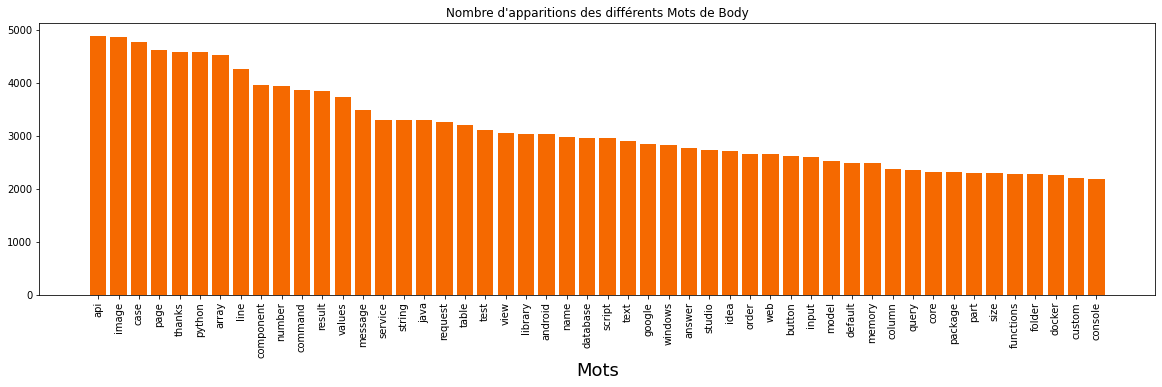

In [ ]:
## Affichage des fréquences

plt.rcParams["figure.figsize"] = [20, 5]
plt.bar('Mots_Body', 'Frequency', data=rslt[:50], color=["#f56900"])
plt.xlabel('Mots', fontsize=18)
plt.xticks(rotation=90)
plt.title('Nombre d\'apparitions des différents Mots de Body')
plt.show()

In [ ]:
## A partir de Google Colab

pd.DataFrame(liste_globale, columns=['liste_globale_body']).to_csv('liste_mots_Topic_global_body.csv', sep = ',', index=False)
files.download('liste_mots_Topic_global_body.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('dict_topics_body.json', 'w') as outfile:
  json.dump(dict_topics_body, outfile)

files.download('dict_topics_body.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dump(best_lda_model, 'best_lda_model_body.joblib')
files.download('best_lda_model_body.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Approche non supervisée : Transformez des données textuelles de la variable 'Title' en features

## Création des features de la variable 'Title' avec la méthode LDA

In [ ]:
## Définition des paramètres du modèle

search_params = {'n_components': [25, 50, 75, 100], 'learning_decay': [0.5, 0.8], 'max_iter' : [5], 'learning_offset' : [50], 'learning_method' : ['online'], 'n_jobs' : [-1], 'max_iter' : [5], 'random_state' : [0]}
lda = LatentDirichletAllocation()
no_top_words = 10

### Sans traitement

In [ ]:
## Création des vecteurs de mots

tf_vectorizer = CountVectorizer(min_df = 2, max_features = 1000)
data_vectorized_sans = tf_vectorizer.fit_transform(data['Title_nettoye_sans'])

In [ ]:
## Validation croisée

model_sans = GridSearchCV(lda, param_grid=search_params)
model_sans.fit(data_vectorized_sans)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
## Evaluation du modèle

best_lda_model_sans = model_sans.best_estimator_
display_topics(best_lda_model_sans, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
object laravel form order mysql types components argument pointer work
Topic 1:
values php vue unit intellij tag router jest div token
Topic 2:
file code table css script path directory jenkins csv jupyter
Topic 3:
data method custom time typescript use exception performance video null
Topic 4:
string javascript user objects key environment arrays permission dependency requests
Topic 5:
function app server service name database template parameter sum firebase
Topic 6:
python docker module windows container model child repository route pip
Topic 7:
pandas dataframe swiftui firebase loop date framework message index entity
Topic 8:
view line chrome access package field output console linux process
Topic 9:
type api version number flutter url selenium rest interface arguments
Topic 10:
core aspnet request library js event call mode format statement
Topic 11:
spring boot background color change reference authentication github position layout
Topic 12:
text angular command numbers 

### Stopwords

In [ ]:
## Création des vecteurs de mots

tf_vectorizer = CountVectorizer(min_df = 2, max_features = 1000)
data_vectorized_stopwords = tf_vectorizer.fit_transform(data['Title_nettoye_stopwords'])

In [ ]:
## Validation croisée

model_stopwords = GridSearchCV(lda, param_grid=search_params)
model_stopwords.fit(data_vectorized_stopwords)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
## Evaluation du modèle

best_lda_model_stopwords = model_stopwords.best_estimator_
display_topics(best_lda_model_stopwords, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
css columns variables pointer interface methods pipeline point style frame
Topic 1:
material keras vue store email warning s3 router implementation vscode
Topic 2:
bar images client components child kubernetes video azure integer route
Topic 3:
property typescript parameter parameters position null recyclerview length angular2 login
Topic 4:
script url model argument selenium strings apps branch bit limit
Topic 5:
service input web nodejs screen system algorithm icon pip body
Topic 6:
user button key row lambda tensorflow arguments space scroll rails
Topic 7:
objects query size loop date constructor arrays password member range
Topic 8:
form field output numbers sum characters process typeerror ui fields
Topic 9:
kotlin stream items rows gradle classes task controller repository extension
Topic 10:
js event rest github csv mongodb post jquery node cors
Topic 11:
database spark authentication content mode format entity load pattern room
Topic 12:
command sql issue npm message d

### Lemmatisation

In [ ]:
## Création des vecteurs de mots

tf_vectorizer = CountVectorizer(min_df = 2, max_features = 1000)
data_vectorized_lem = tf_vectorizer.fit_transform(data['Title_nettoye_lem'])

In [ ]:
## Validation croisée

model_lem = GridSearchCV(lda, param_grid=search_params)
model_lem.fit(data_vectorized_lem)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
## Evaluation du modèle

best_lda_model_lem = model_lem.best_estimator_
display_topics(best_lda_model_lem, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
loop point type document card cognito balanc email edittext bottom
Topic 1:
matrix vue kubectl interceptor int structur reactj prop print ui
Topic 2:
metadata imag str express null cursor pictur locat play plot
Topic 3:
pair pack typescript aw icon popup support admin angular2 login
Topic 4:
tensor forc src group auth ggplot2 report syntaxerror filter display
Topic 5:
lib input site definit nodemodul header consum window video messag
Topic 6:
pass mongodb fragment time space progress linq ubuntu bind control
Topic 7:
provid user kernel object colab backend option resolut array bool
Topic 8:
limit sequenc directori perform const junit notebook namespac excel lifecycl
Topic 9:
argument consol char exampl number export word comparison element refresh
Topic 10:
microsoft eslint html5 notif target mongo stdvector tab foreach jqueri
Topic 11:
content respons vuej label name complex typeerror legend focus invalid
Topic 12:
combin iphon break npm mac config alia linux runtim shortcut


### Stemming

In [ ]:
## Création des vecteurs de mots

tf_vectorizer = CountVectorizer(min_df = 2, max_features = 1000)
data_vectorized_stem = tf_vectorizer.fit_transform(data['Title_nettoye_stem'])

In [ ]:
## Validation croisée

model_stem = GridSearchCV(lda, param_grid=search_params)
model_stem.fit(data_vectorized_stem)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
## Evaluation du modèle

best_lda_model_stem = model_stem.best_estimator_
display_topics(best_lda_model_stem, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
materi type pointer document action class extens ui case collect
Topic 1:
header vue string filter router prop featur axio tabl render
Topic 2:
databas program perform entiti interfac video product powershel null room
Topic 3:
packag typescript aw posit icon sum angular2 set name initi
Topic 4:
view form chrome sql color depend group refer excel cell
Topic 5:
servic contain url cloud background instanc express folder window statement
Topic 6:
properti control charact except client lambda length s3 copi pdf
Topic 7:
oper queri boot authent condit space rest github recyclerview struct
Topic 8:
row button order task vuej option resourc reactj widget anim
Topic 9:
librari argument number mode word format linux email regex pip
Topic 10:
connect event html js sourc tag system token jqueri end
Topic 11:
item stream field column output spark point process pattern pipelin
Topic 12:
command input opencv mac layout typeerror keyboard cli os project
Topic 13:
loop store error dictionari p

### Comparaison des résultats

In [ ]:
## Comparaison des résultats

df = pd.DataFrame(columns = ['Méthode nettoyage', 'Hyperparamètres optimaux', 'Log Likelihood Score', 'Perplexity'])
df.loc[0] = ['Sans traitement', model_sans.best_params_, model_sans.best_score_, best_lda_model_sans.perplexity(data_vectorized_sans)]
df.loc[1] = ['Stopwords', model_stopwords.best_params_, model_stopwords.best_score_, best_lda_model_stopwords.perplexity(data_vectorized_stopwords)]
df.loc[2] = ['Lemmatisation', model_lem.best_params_, model_lem.best_score_, best_lda_model_lem.perplexity(data_vectorized_lem)]
df.loc[3] = ['Stemming', model_stem.best_params_, model_stem.best_score_, best_lda_model_stem.perplexity(data_vectorized_stem)]
df

,Méthode nettoyage,Hyperparamètres optimaux,Log Likelihood Score,Perplexity
0,Sans traitement,"{'learning_decay': 0.8, 'learning_method': 'on...",-186246.022698,832.083826
1,Stopwords,"{'learning_decay': 0.8, 'learning_method': 'on...",-130638.152465,1019.085413
2,Lemmatisation,"{'learning_decay': 0.8, 'learning_method': 'on...",-137323.933939,953.429146
3,Stemming,"{'learning_decay': 0.8, 'learning_method': 'on...",-141897.545014,959.667277


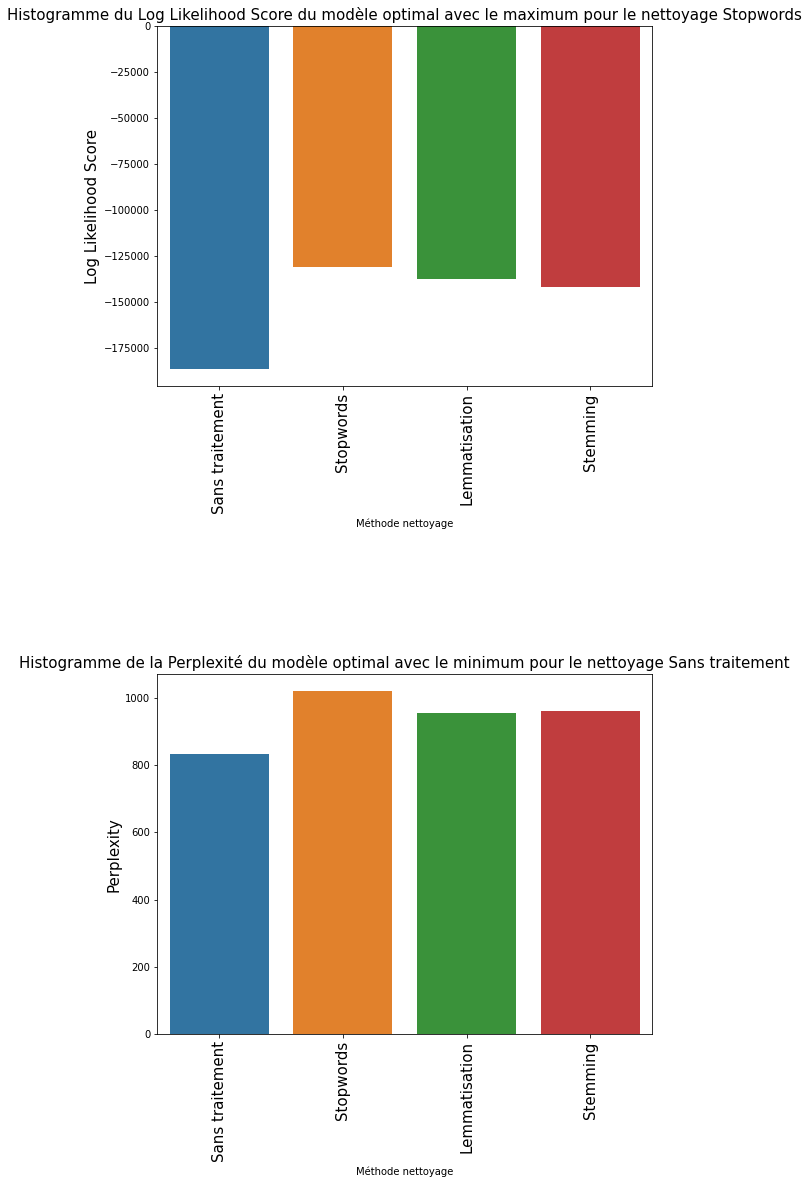

In [ ]:
plt.figure(figsize=(5, 20))

plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.2, hspace = 0.8)

plt.subplot(2,1,1)
sns.barplot(x=df['Méthode nettoyage'],y=df['Log Likelihood Score'])
plt.xticks(fontsize=15, rotation=90)
plt.ylabel("Log Likelihood Score", fontsize=15)
plt.title('Histogramme du Log Likelihood Score du modèle optimal avec le maximum pour le nettoyage {}'.format(df['Méthode nettoyage'][df['Log Likelihood Score'] == df['Log Likelihood Score'].max()].values[0]), fontsize=15)

plt.subplot(2,1,2)
sns.barplot(x=df['Méthode nettoyage'],y=df['Perplexity'])
plt.xticks(fontsize=15, rotation=90)
plt.ylabel("Perplexity", fontsize=15)
plt.title('Histogramme de la Perplexité du modèle optimal avec le minimum pour le nettoyage {}'.format(df['Méthode nettoyage'][df['Perplexity'] == df['Perplexity'].min()].values[0]), fontsize=15)

plt.show()

## Sélection du modèle

In [ ]:
## Sélection du modèle

best_lda_model = best_lda_model_stopwords
data_vectorized = data_vectorized_stopwords
variable = 'Title_nettoye_stopwords'

## Création du DataFrame du poids de chaque Topic

lda_output = best_lda_model.transform(data_vectorized)
topicnames = ["Topic_Title_" + str(i) for i in range(best_lda_model.n_components)]
docnames = [str(i) for i in range(len(data))]
df_document_topic_title = pd.DataFrame(np.round(lda_output, 2), columns = topicnames, index = docnames)

## Topic dominant pour chaque message
dominant_topic_title = np.argmax(df_document_topic_title.values, axis=1)
df_document_topic_title['dominant_topic_Title'] = dominant_topic_title

df_document_topic_title

,Topic_Title_0,Topic_Title_1,Topic_Title_2,Topic_Title_3,Topic_Title_4,Topic_Title_5,Topic_Title_6,Topic_Title_7,Topic_Title_8,Topic_Title_9,Topic_Title_10,Topic_Title_11,Topic_Title_12,Topic_Title_13,Topic_Title_14,Topic_Title_15,Topic_Title_16,Topic_Title_17,Topic_Title_18,Topic_Title_19,Topic_Title_20,Topic_Title_21,Topic_Title_22,Topic_Title_23,Topic_Title_24,dominant_topic_Title
0,0.02,0.02,0.52,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,2
1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.68,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,13
2,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0
3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.68,0.01,0.01,0.01,21
4,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.68,0.01,0.01,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48442,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.52,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,11
48443,0.01,0.26,0.01,0.01,0.01,0.01,0.01,0.26,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.26,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
48444,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0
48445,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.52,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,10


In [ ]:
## Nombre de messages pour chaque Topic

df_topic_distribution = df_document_topic_title['dominant_topic_Title'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,9036
1,2,2821
2,1,2764
3,3,2632
4,5,2624
5,6,2211
6,7,2132
7,4,2048
8,8,1841
9,9,1811


In [ ]:
## Topic dominat de chaque message

data['dominant_topic_Title'] = list(df_document_topic_title['dominant_topic_Title'])

In [ ]:
## Top 20 des mots de chaque topic

NB_top_mots = 20
topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=best_lda_model, n_words=NB_top_mots)        
topic_keywords = pd.DataFrame(topic_keywords)
topic_keywords.columns = ['Word '+str(i) for i in range(topic_keywords.shape[1])]
topic_keywords.index = ['Topic_Title_'+str(i) for i in range(topic_keywords.shape[0])]
topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic_Title_0,css,columns,variables,pointer,interface,methods,pipeline,point,style,frame,host,svg,safari,menu,const,char,conversion,solution,gcc,comparison
Topic_Title_1,material,keras,vue,store,email,warning,s3,router,implementation,vscode,crash,struct,provider,devices,feature,backend,cpu,pointers,amazon,airflow
Topic_Title_2,bar,images,client,components,child,kubernetes,video,azure,integer,route,website,plot,release,db,tab,auto,part,practice,oracle,services
Topic_Title_3,property,typescript,parameter,parameters,position,null,recyclerview,length,angular2,login,control,mvc,jpa,axios,events,connect,signature,hibernate,rust,phone
Topic_Title_4,script,url,model,argument,selenium,strings,apps,branch,bit,limit,anaconda,config,machine,webview,hooks,schema,differences,bytes,env,postman
Topic_Title_5,service,input,web,nodejs,screen,system,algorithm,icon,pip,body,target,ionic,execution,points,font,iphone,issues,pages,tree,upload
Topic_Title_6,user,button,key,row,lambda,tensorflow,arguments,space,scroll,rails,pdf,widget,apk,animation,bundle,maps,unity,domain,max,init
Topic_Title_7,objects,query,size,loop,date,constructor,arrays,password,member,range,activity,condition,structure,scala,declaration,cmake,projects,alternative,foreach,ruby
Topic_Title_8,form,field,output,numbers,sum,characters,process,typeerror,ui,fields,regex,lists,action,testing,modal,postgresql,constraint,dom,groups,bean
Topic_Title_9,kotlin,stream,items,rows,gradle,classes,task,controller,repository,extension,matrix,link,root,dictionary,numpy,port,maven,dates,generator,options


In [ ]:
## Création du dictionnaire du Top 20 de mots de chaque Topic

dict_topics_title = {}

for i in range(topic_keywords.shape[0]):
  dict_topics_title[i] = list(topic_keywords.iloc[i])

In [ ]:
## Création de la liste des mots de tous les Topics

liste_globale = []

for i in range(topic_keywords.shape[0]):
  liste_globale = liste_globale + list(topic_keywords.iloc[i])

In [ ]:
## Création de la liste de mots du Topic dominant

data['Liste_Features_Topic_dominant_Title'] = dominant_topic_title
data['Liste_Features_Topic_dominant_Title'] = data['Liste_Features_Topic_dominant_Title'].map(dict_topics_title)
data

,index,Body,Title,Tags,Body_new,Body_noms,Body_nettoye_sans,Body_nettoye_stopwords,Body_nettoye_lem,Body_nettoye_stem,Title_noms,Title_nettoye_sans,Title_nettoye_stopwords,Title_nettoye_lem,Title_nettoye_stem,Tags_new,Nombre_Tags,Tags_nettoyes,Nombre_Tags_nettoyes,Tags_nettoyes_liste,dominant_topic_Body,Liste_Features_Topic_dominant_Body,match_Topic_dominant_Body,match_Topic_global_Body,Nombre_mots_Body,dominant_topic_Title,Liste_Features_Topic_dominant_Title
0,0,<p>Problem statement: Extract sections from .d...,Is there any way to read .docx file include au...,<python><docx><python-docx>,Problem statement: Extract sections from .docx...,problem statement extract sections docx file a...,problem statement extract sections docx file a...,statement extract sections docx autonumbering ...,statement extract section docx autonumbering p...,statement extract section docx autonumb python...,way docx file auto pythondocx,way docx file auto pythondocx,docx auto pythondocx,docx auto pythondocx,docx auto pythondocx,python docx python-docx,3,python,1,[python],6,"[thanks, text, button, program, advance, threa...",[text],"[statement, text]",9,2,"[bar, images, client, components, child, kuber..."
1,1,<p>I have a 4D xarray Dataset. I want to carry...,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>,I have a 4D xarray Dataset. I want to carry ou...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variable dimension r...,xarray dataset regress variabl dimens regress ...,xarray 1d operations dataset,xarray operations dataset,xarray operations dataset,xarray operation dataset,xarray oper dataset,python dask python-xarray,3,python,1,[python],18,"[python, variable, functions, variables, order...","[parameters, python, variables]","[dataset, array, questions, results, variables...",26,13,"[aws, boot, connection, exception, tests, clic..."
2,2,<p>My original function to determine if a numb...,Check if prime big-o,<c++><big-o><asymptotic-complexity>,My original function to determine if a number ...,function number complexity optimizations check...,function number complexity optimizations check...,number complexity optimizations check bigo pro...,number complexity optimization check bigo prog...,number complex optim check bigo program fact,prime bigo,prime bigo,prime bigo,prime bigo,prime bigo,c++ big-o asymptotic-complexity,3,c++,1,[c++],9,"[view, model, custom, date, plugin, navigation...",[],"[program, check, number]",7,0,"[css, columns, variables, pointer, interface, ..."
3,3,<p>I am trying to understand the meaning of th...,Meaning of dot in lm(y~.) in R,<r>,I am trying to understand the meaning of this ...,meaning statement r code r help section interp...,meaning statement code help section interpreta...,meaning statement section interpretations form...,meaning statement section interpretation formu...,mean statement section interpret formula conte...,meaning dot lmy r,meaning dot lmy,meaning dot lmy,meaning dot lmy,mean dot lmi,r,1,r,1,[r],10,"[state, content, react, context, statement, ur...","[statements, section, statement, argument, con...","[part, columns, functions, section, variables,...",27,21,"[index, window, header, changes, bootstrap, pr..."
4,4,<p>So i'm doing a little personal project but ...,attributeerror: module 'cv2.face' has no attri...,<python><python-3.x><opencv3.0><opencv-contrib>,So i'm doing a little personal project but i k...,project error recognizer opencvcontrib code li...,project error recognizer opencvcontrib code li...,recognizer opencvcontrib line modules thing la...,recognizer opencvcontrib line module thing lap...,recogn opencvcontrib line modul thing laptop d...,attributeerror module attribute createlbphface...,attributeerror module attribute createlbphface...,attributeerror attribute createlbphfacerecognizer,attributeerror attribute createlbphfacerecogniz

In [ ]:
## Création de la liste de features dominantes ie match entre les mots contenus dans le message et les mots du Topic dominant

data['match_Topic_dominant_Title'] = data.apply(lambda row : match_topic_dominant_message(row, variable, row['Liste_Features_Topic_dominant_Title']), axis=1)

In [ ]:
## Création de la liste de features globales ie match entre les mots contenus dans le message et des mots de tous les Topics

data['match_Topic_global_Title'] = data.apply(lambda row : match_topic_dominant_message(row, variable, liste_globale), axis=1)

In [ ]:
data['Nombre_mots_Title'] = data.apply(lambda row: len(row[variable].split()), axis=1)
data

,index,Body,Title,Tags,Body_new,Body_noms,Body_nettoye_sans,Body_nettoye_stopwords,Body_nettoye_lem,Body_nettoye_stem,Title_noms,Title_nettoye_sans,Title_nettoye_stopwords,Title_nettoye_lem,Title_nettoye_stem,Tags_new,Nombre_Tags,Tags_nettoyes,Nombre_Tags_nettoyes,Tags_nettoyes_liste,dominant_topic_Body,Liste_Features_Topic_dominant_Body,match_Topic_dominant_Body,match_Topic_global_Body,Nombre_mots_Body,dominant_topic_Title,Liste_Features_Topic_dominant_Title,match_Topic_dominant_Title,match_Topic_global_Title,Nombre_mots_Title
0,0,<p>Problem statement: Extract sections from .d...,Is there any way to read .docx file include au...,<python><docx><python-docx>,Problem statement: Extract sections from .docx...,problem statement extract sections docx file a...,problem statement extract sections docx file a...,statement extract sections docx autonumbering ...,statement extract section docx autonumbering p...,statement extract section docx autonumb python...,way docx file auto pythondocx,way docx file auto pythondocx,docx auto pythondocx,docx auto pythondocx,docx auto pythondocx,python docx python-docx,3,python,1,[python],6,"[thanks, text, button, program, advance, threa...",[text],"[statement, text]",9,2,"[bar, images, client, components, child, kuber...",[auto],[auto],3
1,1,<p>I have a 4D xarray Dataset. I want to carry...,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>,I have a 4D xarray Dataset. I want to carry ou...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variable dimension r...,xarray dataset regress variabl dimens regress ...,xarray 1d operations dataset,xarray operations dataset,xarray operations dataset,xarray operation dataset,xarray oper dataset,python dask python-xarray,3,python,1,[python],18,"[python, variable, functions, variables, order...","[parameters, python, variables]","[dataset, array, questions, results, variables...",26,13,"[aws, boot, connection, exception, tests, clic...",[],[],3
2,2,<p>My original function to determine if a numb...,Check if prime big-o,<c++><big-o><asymptotic-complexity>,My original function to determine if a number ...,function number complexity optimizations check...,function number complexity optimizations check...,number complexity optimizations check bigo pro...,number complexity optimization check bigo prog...,number complex optim check bigo program fact,prime bigo,prime bigo,prime bigo,prime bigo,prime bigo,c++ big-o asymptotic-complexity,3,c++,1,[c++],9,"[view, model, custom, date, plugin, navigation...",[],"[program, check, number]",7,0,"[css, columns, variables, pointer, interface, ...",[],[],2
3,3,<p>I am trying to understand the meaning of th...,Meaning of dot in lm(y~.) in R,<r>,I am trying to understand the meaning of this ...,meaning statement r code r help section interp...,meaning statement code help section interpreta...,meaning statement section interpretations form...,meaning statement section interpretation formu...,mean statement section interpret formula conte...,meaning dot lmy r,meaning dot lmy,meaning dot lmy,meaning dot lmy,mean dot lmi,r,1,r,1,[r],10,"[state, content, react, context, statement, ur...","[statements, section, statement, argument, con...","[part, columns, functions, section, variables,...",27,21,"[index, window, header, changes, bootstrap, pr...",[],[],3
4,4,<p>So i'm doing a little personal project but ...,attributeerror: module 'cv2.face' has no attri...,<python><python-3.x><opencv3.0><opencv-contrib>,So i'm doing a little personal project but i k...,project error recognizer opencvcontrib code li...,project error recognizer opencvcontrib code li...,recognizer opencvcontrib line modules thing la...,recognizer opencvcontrib line module thing lap...,recogn opencvcontrib line modul thing laptop d...,attributeerror module attribute createlbphface...,attributeerror module attribute creat

In [ ]:
## Fréquence de chaque Tag

mots_title = data[variable].str.cat(sep=' ')
words = mots_title.split()
Word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(Word_dist.most_common(),columns=['Mots_Title', 'Frequency'])
rslt['Freq_cumulee'] = rslt["Frequency"].cumsum()
rslt

,Mots_Title,Frequency,Freq_cumulee
0,typescript,413,413
1,page,410,823
2,command,410,1233
3,xcode,410,1643
4,user,406,2049
...,...,...,...
19913,comcompanyappname,1,137576
19914,thunderbolt,1,137577
19915,onehot,1,137578
19916,navigationend,1,137579


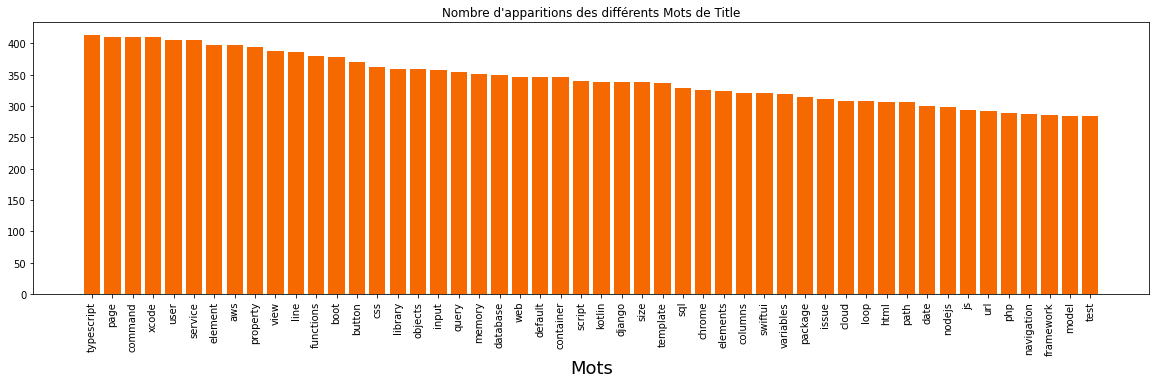

In [ ]:
## Affichage des fréquences

plt.rcParams["figure.figsize"] = [20, 5]
plt.bar('Mots_Title', 'Frequency', data=rslt[:50], color=["#f56900"])
plt.xlabel('Mots', fontsize=18)
plt.xticks(rotation=90)
plt.title('Nombre d\'apparitions des différents Mots de Title')
plt.show()

In [ ]:
## A partir de Google Colab

pd.DataFrame(liste_globale, columns=['liste_globale_title']).to_csv('liste_mots_Topic_global_title.csv', sep = ',', index=False)
files.download('liste_mots_Topic_global_title.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('dict_topics_title.json', 'w') as outfile:
  json.dump(dict_topics_body, outfile)

files.download('dict_topics_title.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dump(best_lda_model, 'best_lda_model_title.joblib')
files.download('best_lda_model_title.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exportation du jeu de données

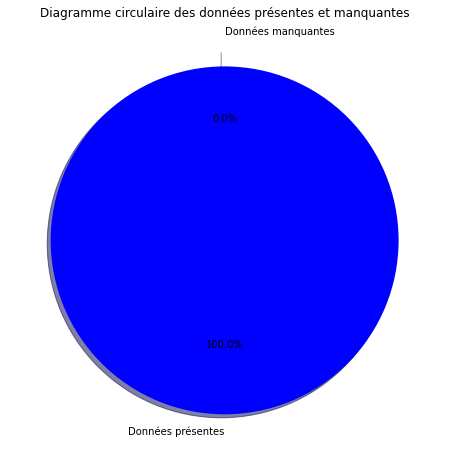

In [ ]:
## Graphe du nombre de données manquantes

plt.rcParams["figure.figsize"] = (8, 8)
graphe_donnees_manquantes(data)

In [ ]:
print("Le DataFrame nettoyé est composé de", data.shape[0], "lignes et de", data.shape[1], "colonnes.")

Le DataFrame nettoyé est composé de 48447 lignes et de 30 colonnes.


In [ ]:
data_final = data[['Body_nettoye_stopwords', 'Title_nettoye_stopwords', 'Tags_nettoyes', 'dominant_topic_Body', 'match_Topic_dominant_Body', 'match_Topic_global_Body', 'dominant_topic_Title', 'match_Topic_dominant_Title', 'match_Topic_global_Title']]
data_final

,Body_nettoye_stopwords,Title_nettoye_stopwords,Tags_nettoyes,dominant_topic_Body,match_Topic_dominant_Body,match_Topic_global_Body,dominant_topic_Title,match_Topic_dominant_Title,match_Topic_global_Title
0,statement extract sections docx autonumbering ...,docx auto pythondocx,python,6,[text],"[statement, text]",2,[auto],[auto]
1,xarray dataset regression variables dimension ...,xarray operations dataset,python,18,"[parameters, python, variables]","[dataset, array, questions, results, variables...",13,[],[]
2,number complexity optimizations check bigo pro...,prime bigo,c++,9,[],"[program, check, number]",0,[],[]
3,meaning statement section interpretations form...,meaning dot lmy,r,10,"[statements, section, statement, argument, con...","[part, columns, functions, section, variables,...",21,[],[]
4,recognizer opencvcontrib line modules thing la...,attributeerror attribute createlbphfacerecognizer,"python, python-3.x",8,"[modules, release]","[release, line, python, modules]",22,[attribute],[attribute]
...,...,...,...,...,...,...,...,...,...
48442,ios mode mode apple documentation emulator att...,mode,"ios, swift",11,"[controller, mode]","[ios, mode, key, support, device, documentatio...",11,[mode],[mode]
48443,android steps links httpsfacebookgithubioreact...,activity lifecycle state,"android, reactjs, react-native",24,[activity],"[android, activity, react]",1,[],"[state, activity]"
48444,logo page part topi scroll site logo backgroun...,transformation logo movement,"javascript, jquery, html, css",3,[background],"[part, background, page, site, picture]",0,[],[]
48445,push notifications tokenization libraries jose...,jwt apn tokenization,"c#, .net",19,[token],"[key, documentation, libraries, notifications,...",10,[jwt],[jwt]


In [ ]:
## A partir de Google Colab

data_final.to_csv('QueryResults_clean.csv', sep = ',', index=False)
files.download('QueryResults_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploration des données

In [ ]:
data.head(3)

,index,Body,Title,Tags,Body_new,Body_noms,Body_nettoye_sans,Body_nettoye_stopwords,Body_nettoye_lem,Body_nettoye_stem,Title_noms,Title_nettoye_sans,Title_nettoye_stopwords,Title_nettoye_lem,Title_nettoye_stem,Tags_new,Nombre_Tags,Tags_nettoyes,Nombre_Tags_nettoyes,Tags_nettoyes_liste,dominant_topic_Body,Liste_Features_Topic_dominant_Body,match_Topic_dominant_Body,match_Topic_global_Body,Nombre_mots_Body,dominant_topic_Title,Liste_Features_Topic_dominant_Title,match_Topic_dominant_Title,match_Topic_global_Title,Nombre_mots_Title
0,0,<p>Problem statement: Extract sections from .d...,Is there any way to read .docx file include au...,<python><docx><python-docx>,Problem statement: Extract sections from .docx...,problem statement extract sections docx file a...,problem statement extract sections docx file a...,statement extract sections docx autonumbering ...,statement extract section docx autonumbering p...,statement extract section docx autonumb python...,way docx file auto pythondocx,way docx file auto pythondocx,docx auto pythondocx,docx auto pythondocx,docx auto pythondocx,python docx python-docx,3,python,1,[python],6,"[thanks, text, button, program, advance, threa...",[text],"[statement, text]",9,2,"[bar, images, client, components, child, kuber...",[auto],[auto],3
1,1,<p>I have a 4D xarray Dataset. I want to carry...,"With xarray, how to parallelize 1D operations ...",<python><dask><python-xarray>,I have a 4D xarray Dataset. I want to carry ou...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variables dimension ...,xarray dataset regression variable dimension r...,xarray dataset regress variabl dimens regress ...,xarray 1d operations dataset,xarray operations dataset,xarray operations dataset,xarray operation dataset,xarray oper dataset,python dask python-xarray,3,python,1,[python],18,"[python, variable, functions, variables, order...","[parameters, python, variables]","[dataset, array, questions, results, variables...",26,13,"[aws, boot, connection, exception, tests, clic...",[],[],3
2,2,<p>My original function to determine if a numb...,Check if prime big-o,<c++><big-o><asymptotic-complexity>,My original function to determine if a number ...,function number complexity optimizations check...,function number complexity optimizations check...,number complexity optimizations check bigo pro...,number complexity optimization check bigo prog...,number complex optim check bigo program fact,prime bigo,prime bigo,prime bigo,prime bigo,prime bigo,c++ big-o asymptotic-complexity,3,c++,1,[c++],9,"[view, model, custom, date, plugin, navigation...",[],"[program, check, number]",7,0,"[css, columns, variables, pointer, interface, ...",[],[],2


In [ ]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48447 entries, 0 to 48446
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   index                                48447 non-null  int64 
 1   Body                                 48447 non-null  object
 2   Title                                48447 non-null  object
 3   Tags                                 48447 non-null  object
 4   Body_new                             48447 non-null  object
 5   Body_noms                            48447 non-null  object
 6   Body_nettoye_sans                    48447 non-null  object
 7   Body_nettoye_stopwords               48447 non-null  object
 8   Body_nettoye_lem                     48447 non-null  object
 9   Body_nettoye_stem                    48447 non-null  object
 10  Title_noms                           48447 non-null  object
 11  Title_nettoye_sans                   4844

In [ ]:
var_quanti = ['Nombre_Tags_nettoyes', 'Nombre_mots_Body', 'Nombre_mots_Title']
var_quali = ['dominant_topic_Body', 'dominant_topic_Title']

data['dominant_topic_Body'] = data['dominant_topic_Body'].astype(CategoricalDtype(ordered=True))
data['dominant_topic_Title'] = data['dominant_topic_Title'].astype(CategoricalDtype(ordered=True))

## Définition des fonctions

### Analyse univariée d'une variable quantitative

In [ ]:
## Encadrement théorique de la moyenne et de la variance théorique ie intervalle de confiance à 95%

def encadrement_moy_var_theo_quanti(data1, c):
  xbar = np.mean(data1[c])
  sprime = np.std(data1[c], ddof=1)
  n_data1 = len(data1)
  sprime2 = np.var(data1[c], ddof=1)
  alpha = 0.05
  
  icinf=xbar-st.t.ppf(1-alpha/2,n_data1-1)*sprime/math.sqrt(n_data1)
  icsup=xbar+st.t.ppf(1-alpha/2,n_data1-1)*sprime/math.sqrt(n_data1)
  print("La moyenne théorique de", c, "est comprise entre", round(icinf,2), "et", round(icsup,2))
  
  icinf = (n_data1-1)*sprime2/st.chi2.ppf(1-alpha/2,n_data1-1)
  icsup = (n_data1-1)*sprime2/st.chi2.ppf(alpha/2,n_data1-1)
  print("La variance théorique de", c, "est comprise entre", round(icinf,2), "et", round(icsup,2))

In [ ]:
def analyses_univariees_quanti(data1, var):
  print('Moyenne de', var, ':', data1[var].mean())
  print('Variance de', var, ': ', data1[var].var(ddof=0))
  encadrement_moy_var_theo_quanti(data1, var)
  print('Médiane de', var, ':', data1[var].median())
  print('Mode de', var, ': ', data1[var].mode())
  print('Ecart-type de', var, ':', data1[var].std(ddof=0))
  print('Skewness de', var, ':', data1[var].skew())
  print('Kurtosis de', var, ':', data1[var].kurtosis())
  print('Boxplot de', var, ':')
  sns.set_theme(style="whitegrid")
  ax = sns.boxplot(x=data1[var])  
  plt.show()

In [ ]:
def indice_de_gini(data1, var):
  dep = data1[var].dropna()
  n = len(dep)
  lorenz = np.cumsum(np.sort(dep)) / dep.sum()
  lorenz = np.append([0],lorenz)
  plt.axes().axis('equal')
  xaxis = np.linspace(0-1/n,1+1/n,n+1)
  plt.plot(xaxis,lorenz,drawstyle='steps-post')
  plt.plot([0,1], [0,1], color='r', alpha=0.5)
  plt.axis([-0.2, 1, -0.1, 1.1])
  plt.title('Courbe de Lorenz de ' + var)
  plt.show()
  
  AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
  S = 0.5 - AUC
  gini = 2*S
  print('Indice de Gini de', var, 'est :', gini)

In [ ]:
def distibution(data, var):
  xbar=data[var].mean()
  plt.rcParams["figure.figsize"] = (20, 8)
  sns.distplot(data[var], kde_kws={"color": "k", "lw": 2, "label": "KDE"}).set_title('Plot et distribution de ' + var)
  plt.axvline(xbar, color='r', linewidth=2)
  plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique")])

### Analyse univariée d'une variable qualitative

In [ ]:
## Pour une variable qualitative

def analyses_univariees_quali(data, var):
  ## Tableau de fréquence
  d = pd.DataFrame(data[var].value_counts(normalize=True))
  print(d)
  ## Diagramme en secteurs
  plt.rcParams["figure.figsize"] = (5, 5)
  data[var].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=90)
  plt.axis('equal')
  plt.title('Diagramme en secteurs de ' + var)
  plt.ylabel('')
  labels = data[var].index 
  plt.legend(labels, loc = 'upper right')
  plt.show()

In [ ]:
## Histogramme
def histo_quali(data, var):
  plt.rcParams["figure.figsize"] = (20, 10)
  sns.set(style="white", rc={"axes.grid":True})
  ax = sns.countplot(x=var, data=data, saturation = 1)
  total = float(len(data)) 
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3,'{:1.2f}'.format(height/total),ha="center") 
  ax.set_title('Histogramme de ' + var)
  ax = ax.set(xlabel=var, ylabel='Nombre produits')
  plt.show()

### Analyse bivariée entre 2 variables quantitatives

In [ ]:
## Diagramme de dispersion entre 2 variables quantitatives

def diagramme_dipersion(X, Y, data):
  plt. figure(figsize = (10, 10))
  plt.plot(data[X],data[Y],'o',alpha=0.5)
  plt.xlabel(X)
  plt.ylabel(Y)
  plt.title("Diagramme de dispersion")
  plt.show()

In [ ]:
## Analyse bivariée entre 2 variables quantitatives : Régression linéaire

def coeff_stat(X, Y, data):
  print("Corrélation de Pearson :", st.pearsonr(data[X],data[Y])[0])
  np.cov(data[X],data[Y],ddof=0) # matrice de corrélation  
  sns.jointplot(x = X, y = Y, data = data, kind = "reg")
  plt.suptitle("Diagramme de dispersion et droite de régression linéaire")

### Analyse bivariée entre 1 variable quantitative et 1 variable qualitative

In [ ]:
## Boxplot d'une variable quantitative en fonction des modalités de la variable qualitative

def graphe_uni_quanti_quali(X, Y, data):
  modalites = data[X].unique()
  groupes = []
  for m in modalites:
    groupes.append(data[data[X]==m][Y])
  
  medianprops = {'color':"black"}
  meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
  plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
  plt.title('Boxplot et moyennes de ' + Y + ' par catégories de ' + X)
  plt.show()

In [ ]:
## Analyse bivariée entre une variable quantitative et qualitative : ANOVA

def eta_squared(X, Y, data):
  x = data[X]
  y = data[Y]
  moyenne_y = y.mean()
  classes = []
  for classe in x.unique():
    yi_classe = y[x==classe]
    classes.append({'ni': len(yi_classe),
                    'moyenne_classe': yi_classe.mean()})
  SCT = sum([(yj-moyenne_y)**2 for yj in y])
  SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
  return '=Rapport de corrélation n² =', SCE/SCT

### Analyse bivariée entre 2 variables qualitatives

In [ ]:
## Analyse bivariée entre 2 variables qualitatives : Test du Chi2 et Tableau de contingence

def test_Chi2(data, X, Y):
  cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total", fill_value=0)
  print('Tableau de contingence')
  display(cont)
  st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
  print('Statistique de test :', st_chi2)
  print('Nombre de ddl :', st_dof)
  print('p-value :', st_p)
  print('Tableau des fréquences obtenues:')

In [ ]:
def tableau_contingence(data, X, Y):
  sns.heatmap(pd.crosstab(data[X], data[Y]), annot=True)
  plt.title("Tableau de contingence coloré")
  plt.show()

### Réduction dimensionnelle

In [ ]:
from matplotlib.collections import LineCollection

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

## ANALYSES UNIVARIEES

In [ ]:
data[var_quali].describe(include='all')

,dominant_topic_Body,dominant_topic_Title
count,48447,48447
unique,25,25
top,19,0
freq,3355,9036


In [ ]:
data[var_quanti].describe(include='all')

,Nombre_Tags_nettoyes,Nombre_mots_Body,Nombre_mots_Title
count,48447.000000,48447.000000,48447.000000
mean,1.613619,21.361674,2.839804
std,0.915588,20.561937,1.360880
min,0.000000,1.000000,1.000000
25%,1.000000,9.000000,2.000000
50%,2.000000,16.000000,3.000000
75%,2.000000,26.000000,4.000000
max,5.000000,579.000000,12.000000


### Variables qualitatives

Pour la variable dominant_topic_Body

    dominant_topic_Body
19             0.069251
18             0.066650
13             0.066485
7              0.063822
12             0.062006
5              0.058910
20             0.055504
23             0.052779
0              0.044358
9              0.040085
2              0.037918
8              0.037360
6              0.035069
21             0.035007
3              0.034883
1              0.034264
15             0.033521
22             0.032303
16             0.032014
4              0.021818
10             0.018763
11             0.018680
14             0.017545
24             0.016534
17             0.014469


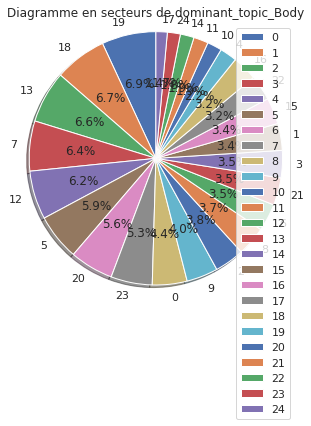

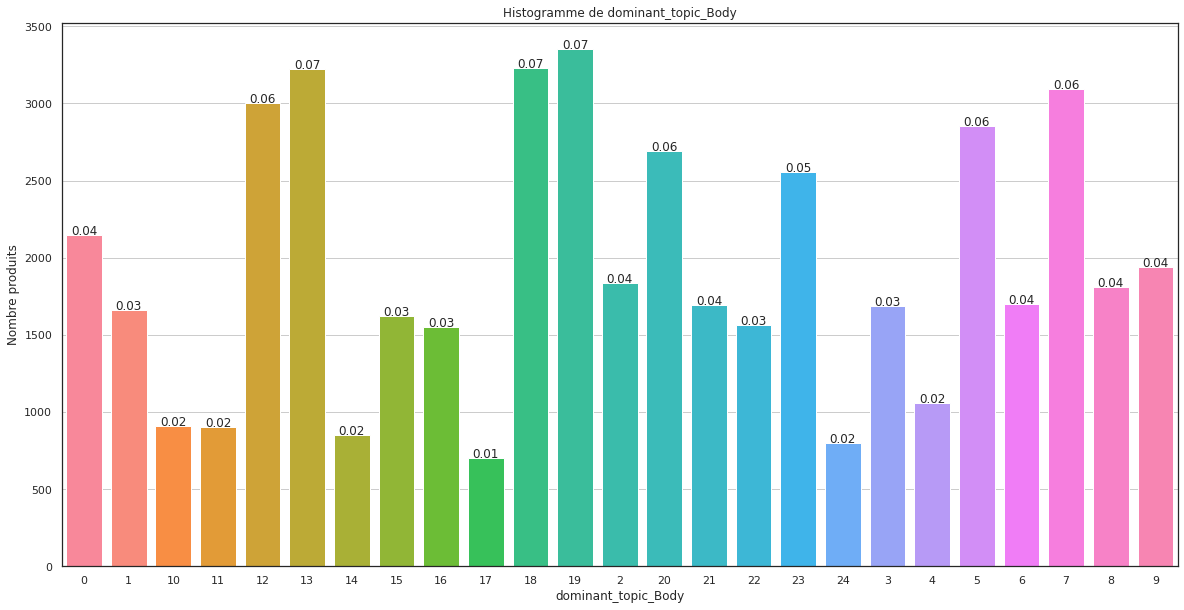



-----------------------------------------------------------


Pour la variable dominant_topic_Title

    dominant_topic_Title
0               0.186513
2               0.058229
1               0.057052
3               0.054327
5               0.054162
6               0.045638
7               0.044007
4               0.042273
8               0.038000
9               0.037381
11              0.035523
12              0.033851
13              0.032303
15              0.031147
10              0.029269
18              0.027391
16              0.026813
14              0.026421
19              0.023180
20              0.022788
17              0.021322
21              0.019299
22              0.019155
23              0.017359
24              0.016595


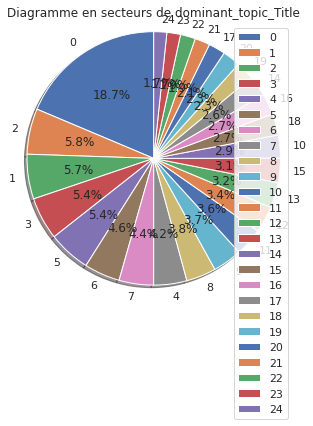

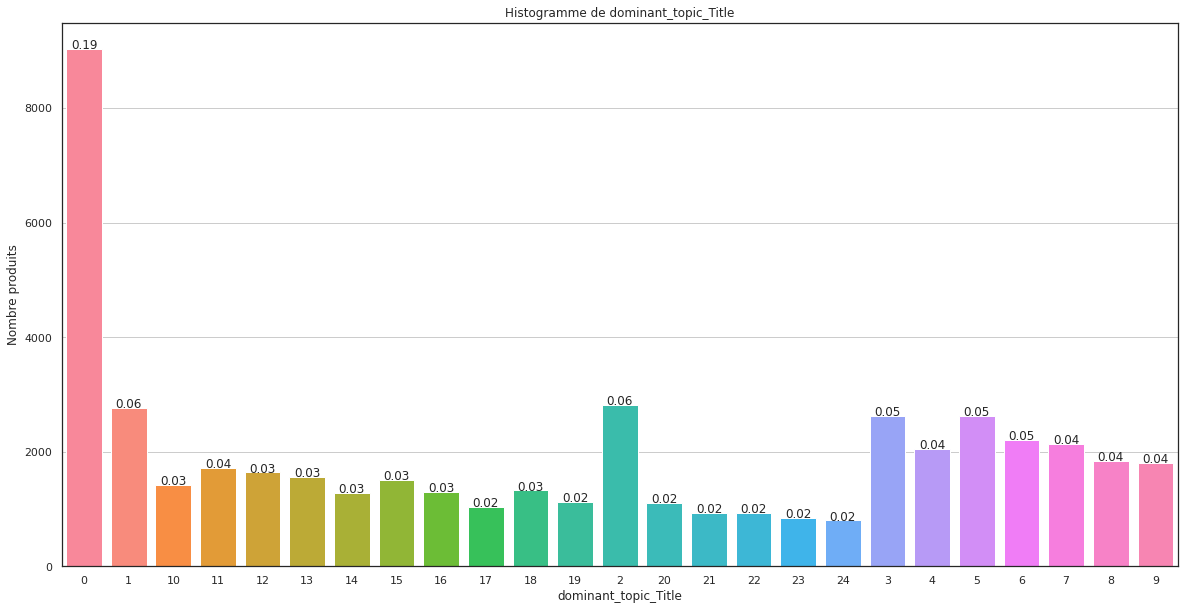



-----------------------------------------------------------




In [ ]:
for i in range(len(var_quali)):
  print('Pour la variable ' + var_quali[i] + '\n')
  analyses_univariees_quali(data, var_quali[i])
  print('\n')
  histo_quali(data, var_quali[i])
  print('\n')
  print('-----------------------------------------------------------')
  print('\n')

### Variables quantitatives

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

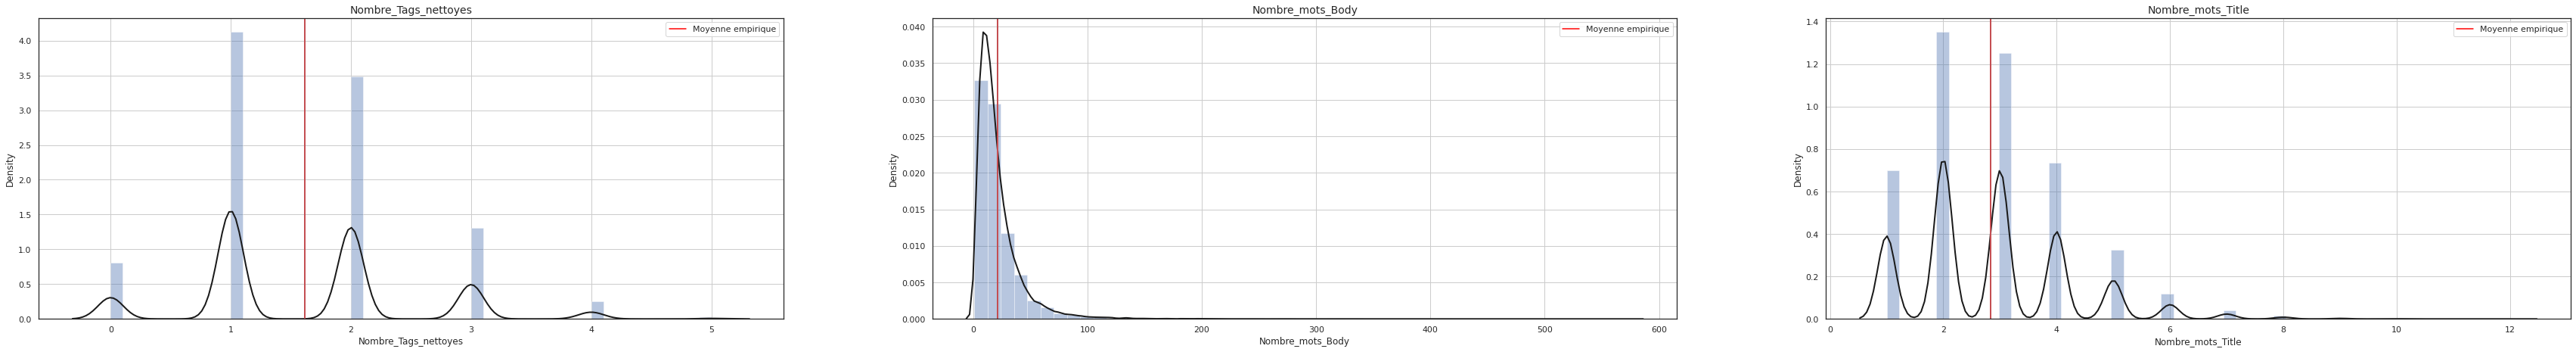

In [ ]:
## Histogramme de chaque variable
fig = plt.figure(figsize=(60, 60))
for i in range(len(var_quanti)):
    ax = fig.add_subplot(7,3, (i+1))
    h = distibution(data, var_quanti[i])
    ax.set_title(var_quanti[i], fontsize=14)

Pour la variable Nombre_Tags_nettoyes
Moyenne de Nombre_Tags_nettoyes : 1.6136190063368216
Variance de Nombre_Tags_nettoyes :  0.8382837777286265
La moyenne théorique de Nombre_Tags_nettoyes est comprise entre 1.61 et 1.62
La variance théorique de Nombre_Tags_nettoyes est comprise entre 0.83 et 0.85
Médiane de Nombre_Tags_nettoyes : 2.0
Mode de Nombre_Tags_nettoyes :  0    1
dtype: int64
Ecart-type de Nombre_Tags_nettoyes : 0.9155783842624434
Skewness de Nombre_Tags_nettoyes : 0.4651922010550197
Kurtosis de Nombre_Tags_nettoyes : 0.11404843413728027
Boxplot de Nombre_Tags_nettoyes :


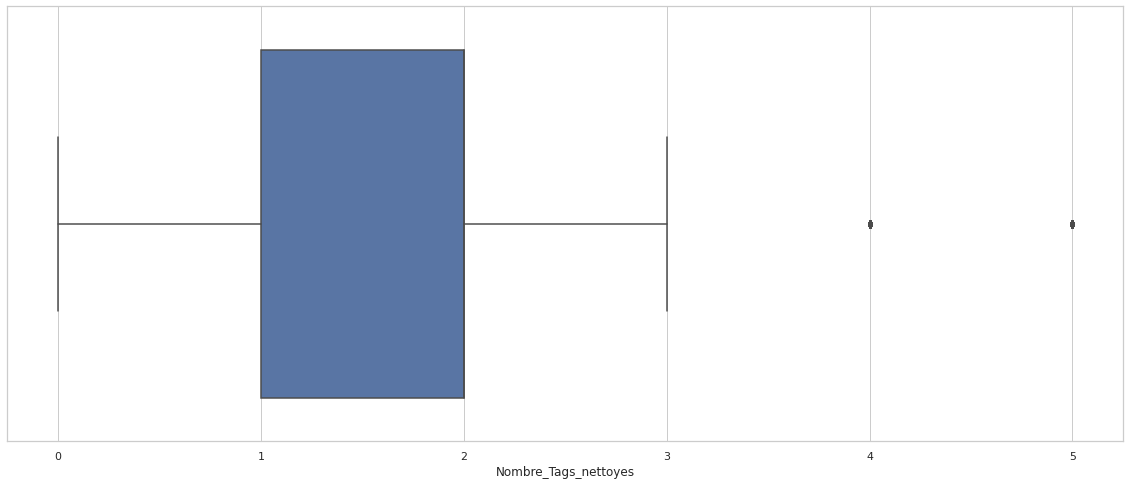

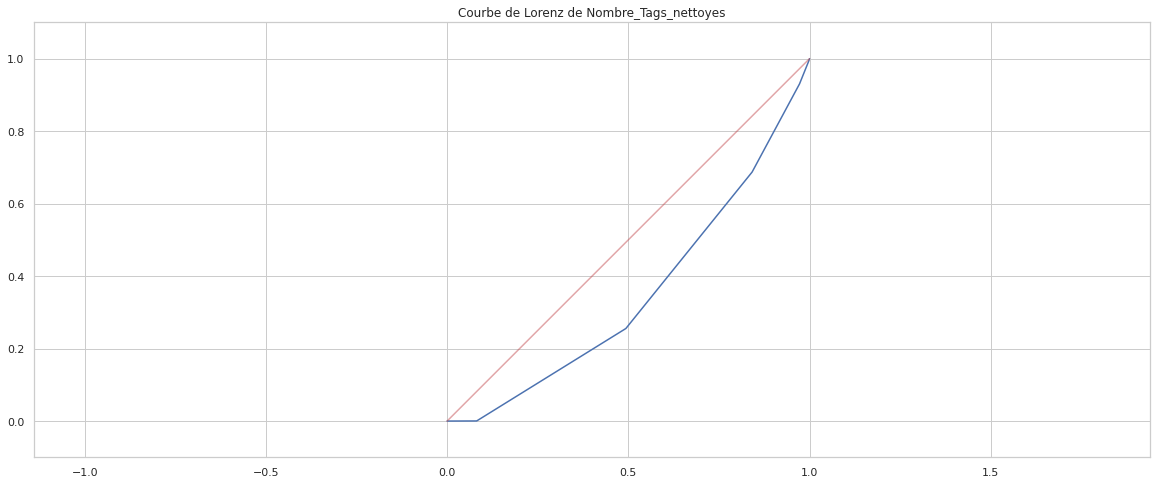

Indice de Gini de Nombre_Tags_nettoyes est : 0.3015607692749397




/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))




-----------------------------------------------------------


Pour la variable Nombre_mots_Body
Moyenne de Nombre_mots_Body : 21.36167358143951
Variance de Nombre_mots_Body :  422.78454301618154
La moyenne théorique de Nombre_mots_Body est comprise entre 21.18 et 21.54
La variance théorique de Nombre_mots_Body est comprise entre 417.52 et 428.17
Médiane de Nombre_mots_Body : 16.0
Mode de Nombre_mots_Body :  0    8
dtype: int64
Ecart-type de Nombre_mots_Body : 20.56172519552242
Skewness de Nombre_mots_Body : 4.481878323886181
Kurtosis de Nombre_mots_Body : 47.84187656178685
Boxplot de Nombre_mots_Body :


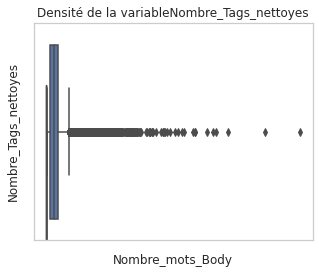

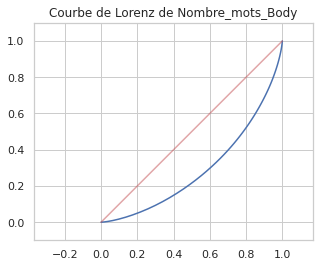

Indice de Gini de Nombre_mots_Body est : 0.4243482661204019




/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))




-----------------------------------------------------------


Pour la variable Nombre_mots_Title
Moyenne de Nombre_mots_Title : 2.839804322249056
Variance de Nombre_mots_Title :  1.851956186037951
La moyenne théorique de Nombre_mots_Title est comprise entre 2.83 et 2.85
La variance théorique de Nombre_mots_Title est comprise entre 1.83 et 1.88
Médiane de Nombre_mots_Title : 3.0
Mode de Nombre_mots_Title :  0    2
dtype: int64
Ecart-type de Nombre_mots_Title : 1.3608659691674088
Skewness de Nombre_mots_Title : 0.8526219274371453
Kurtosis de Nombre_mots_Title : 1.082165919026238
Boxplot de Nombre_mots_Title :


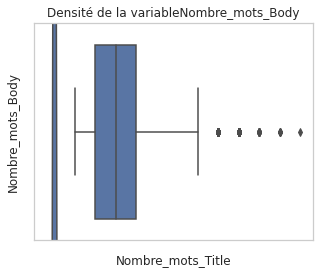

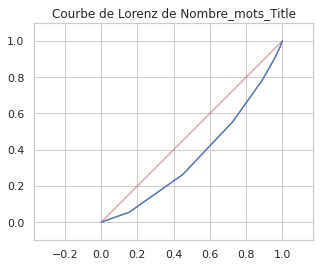

Indice de Gini de Nombre_mots_Title est : 0.2583360424981642




/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))




-----------------------------------------------------------




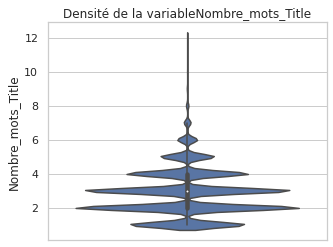

In [ ]:
for i in range(len(var_quanti)):
  print('Pour la variable ' + var_quanti[i])
  analyses_univariees_quanti(data, var_quanti[i])
  print('\n')
  indice_de_gini(data, var_quanti[i])
  print('\n')
  plt.rcParams["figure.figsize"] = (5, 4)
  sns.violinplot(y = var_quanti[i], data = data, orient="h").set_title('Densité de la variable' + var_quanti[i])
  print('\n')
  print('-----------------------------------------------------------')
  print('\n')

## ANALYSES BIVARIEES

Relation entre Nombre_mots_Body et Nombre_Tags_nettoyes


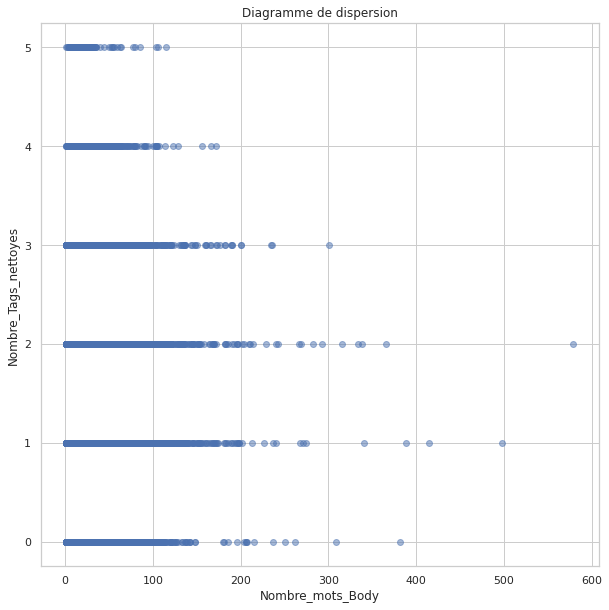

Corrélation de Pearson : -0.011013382346912707


---------------------------------------------------------------


Relation entre Nombre_mots_Title et Nombre_Tags_nettoyes


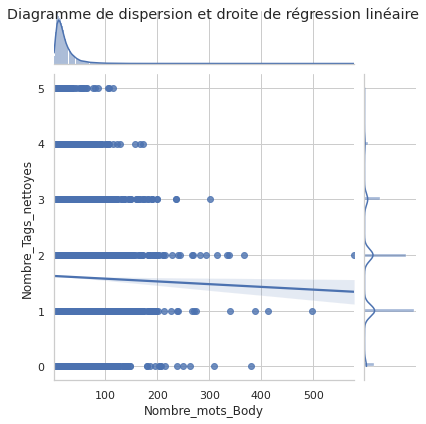

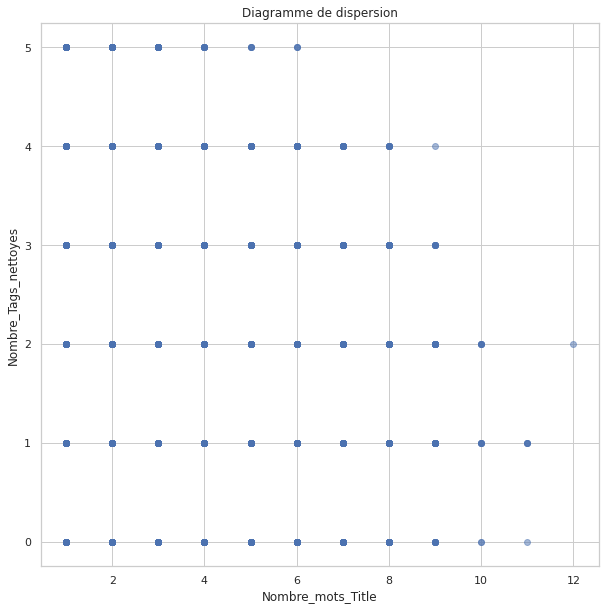

Corrélation de Pearson : -0.05916945257714247


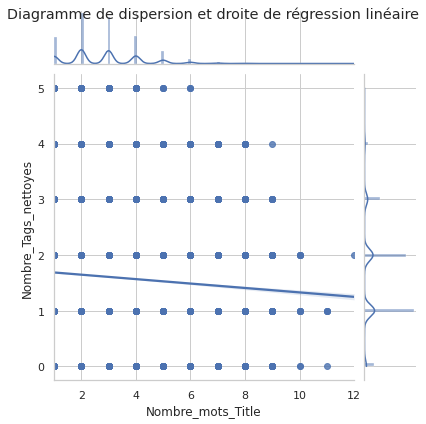

In [ ]:
# Relations entre 2 variables quantitatives : Régression linéaire

## Relation entre 'Nombre_mots_Body' et 'Nombre_Tags_nettoyes'
X = 'Nombre_mots_Body'
Y = 'Nombre_Tags_nettoyes'
print('Relation entre', X, 'et', Y)
diagramme_dipersion(X, Y, data)
coeff_stat(X, Y, data)
print('\n')
print('---------------------------------------------------------------')
print('\n')

## Relation entre 'Nombre_mots_Title' et 'Nombre_Tags_nettoyes'
X = 'Nombre_mots_Title'
Y = 'Nombre_Tags_nettoyes'
print('Relation entre', X, 'et', Y)
diagramme_dipersion(X, Y, data)
coeff_stat(X, Y, data)

Relation entre dominant_topic_Body et Nombre_Tags_nettoyes


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


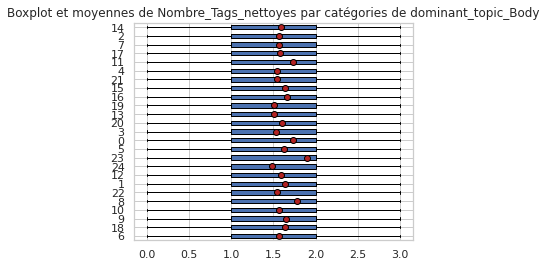

('=Rapport de corrélation n² =', 0.011057432264386815)


---------------------------------------------------------------


Relation entre dominant_topic_Title et Nombre_Tags_nettoyes


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


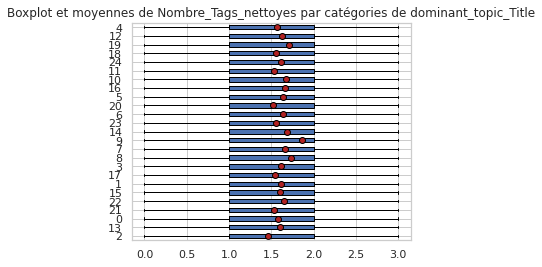

('=Rapport de corrélation n² =', 0.0069994083449037405)


---------------------------------------------------------------


Relation entre dominant_topic_Body et Nombre_mots_Body


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


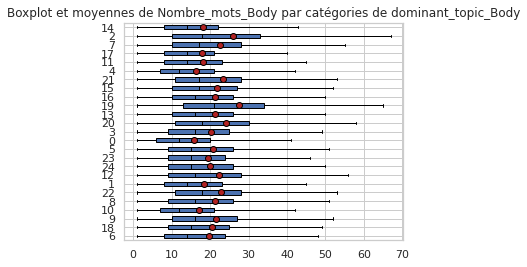

('=Rapport de corrélation n² =', 0.018355927559034653)


---------------------------------------------------------------


Relation entre dominant_topic_Title et Nombre_mots_Title


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


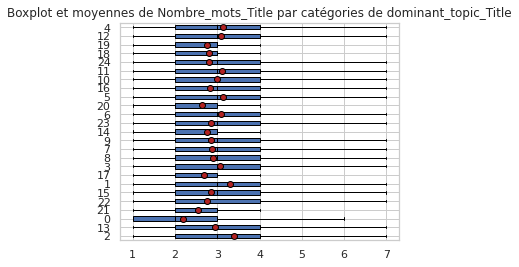

('=Rapport de corrélation n² =', 0.07237676078337955)


In [ ]:
# Relations entre un variable quantitative et une variable qualitative : ANOVA

## Relation entre 'Nombre_Tags_nettoyes' et 'dominant_topic_Body'
Y = 'Nombre_Tags_nettoyes' # quanti
X = 'dominant_topic_Body' # quali
print('Relation entre', X, 'et', Y)
graphe_uni_quanti_quali(X, Y, data)
print(eta_squared(X, Y, data))
print('\n')
print('---------------------------------------------------------------')
print('\n')

## Relation entre 'Nombre_Tags_nettoyes' et 'dominant_topic_Title'
Y = 'Nombre_Tags_nettoyes' # quanti
X = 'dominant_topic_Title' # quali
print('Relation entre', X, 'et', Y)
graphe_uni_quanti_quali(X, Y, data)
print(eta_squared(X, Y, data))
print('\n')
print('---------------------------------------------------------------')
print('\n')

## Relation entre 'Nombre_mots_Body' et 'dominant_topic_Body'
Y = 'Nombre_mots_Body' # quanti
X = 'dominant_topic_Body' # quali
print('Relation entre', X, 'et', Y)
graphe_uni_quanti_quali(X, Y, data)
print(eta_squared(X, Y, data))
print('\n')
print('---------------------------------------------------------------')
print('\n')

## Relation entre 'Nombre_mots_Title' et 'dominant_topic_Title'
Y = 'Nombre_mots_Title' # quanti
X = 'dominant_topic_Title' # quali
print('Relation entre', X, 'et', Y)
graphe_uni_quanti_quali(X, Y, data)
print(eta_squared(X, Y, data))

Relation entre dominant_topic_Body et dominant_topic_Title


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Histogramme de dominant_topic_Body en fonction de dominant_topic_Title')

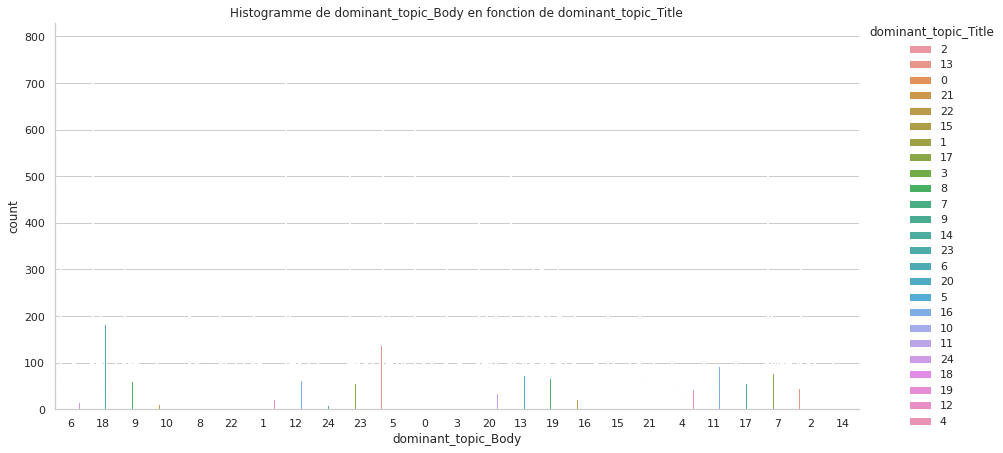

In [ ]:
# Relations entre 2 variables qualitatives : Test du Chi2

## Relation entre 'dominant_topic_Body' et 'dominant_topic_Title'
X = 'dominant_topic_Body'
Y = 'dominant_topic_Title'
print('Relation entre', X, 'et', Y)

data[var_quali] = data[var_quali].astype(str)

sns.factorplot(x = X, hue = Y, data = data, kind = "count", size=6, aspect=2)
plt.title('Histogramme de dominant_topic_Body en fonction de dominant_topic_Title')

Tableau de contingence


dominant_topic_Title,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,3,4,5,6,7,8,9,Total
dominant_topic_Body,,,,,,,,,,,,,,,,,,,,,,,,,,
0,606,90,38,111,22,80,37,44,50,49,36,28,83,37,36,39,27,42,92,62,32,97,125,96,190,2149
1,246,129,37,45,22,30,20,42,46,49,50,22,170,29,24,27,23,30,158,45,69,77,50,183,37,1660
10,176,82,27,34,13,23,23,32,62,14,22,13,29,15,26,12,16,9,54,65,50,34,22,35,21,909
11,126,37,29,45,31,21,18,42,93,36,20,7,56,12,14,11,19,11,59,28,61,25,31,26,47,905
12,786,207,82,50,88,77,76,52,63,55,87,96,83,182,51,51,21,32,198,103,112,93,194,64,101,3004
13,538,150,75,83,363,96,84,169,69,37,151,106,118,73,43,63,63,81,74,184,229,108,85,82,97,3221
14,155,72,32,24,19,20,39,23,36,12,11,11,39,18,11,11,16,12,55,35,21,28,35,72,43,850
15,245,55,69,50,54,44,32,73,23,74,65,91,87,18,28,38,21,17,115,109,74,82,37,40,83,1624
16,274,85,29,58,101,37,30,31,36,40,116,31,129,22,21,23,62,19,75,52,68,78,40,45,49,1551


Statistique de test : 9811.776774874437
Nombre de ddl : 625
p-value : 0.0
Tableau des fréquences obtenues:


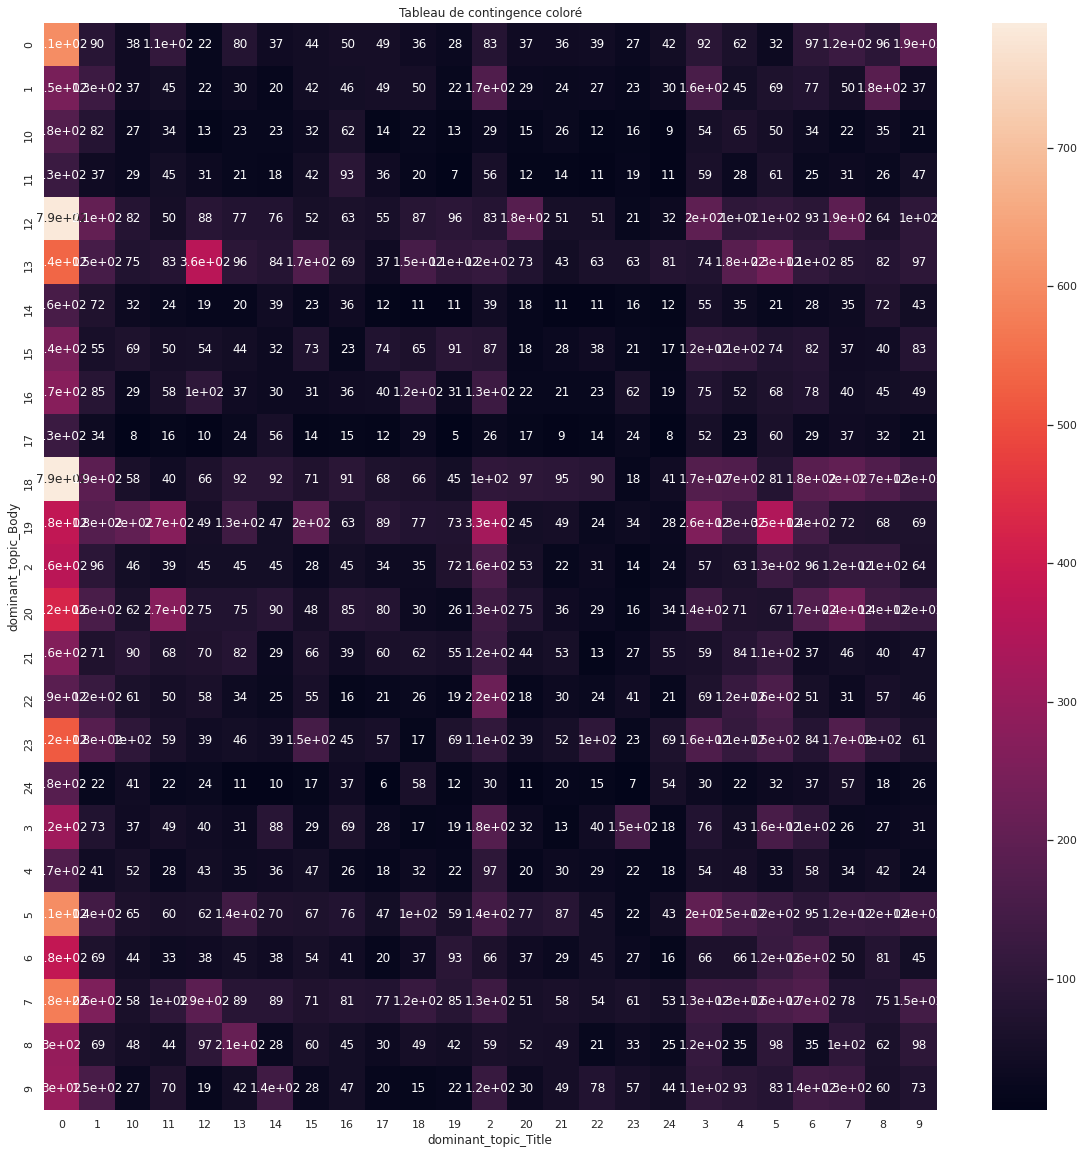

In [ ]:
test_Chi2(data, X, Y)
plt.rcParams["figure.figsize"] = (20, 20)
tableau_contingence(data, X, Y)